In [1]:
!pip install --user scikit-learn==0.23.2 

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''


'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [3]:
# sklearn.__version__ is 0.23.2
sklearn.__version__

'0.23.2'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [6]:
# Overview
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
# General summary of the data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

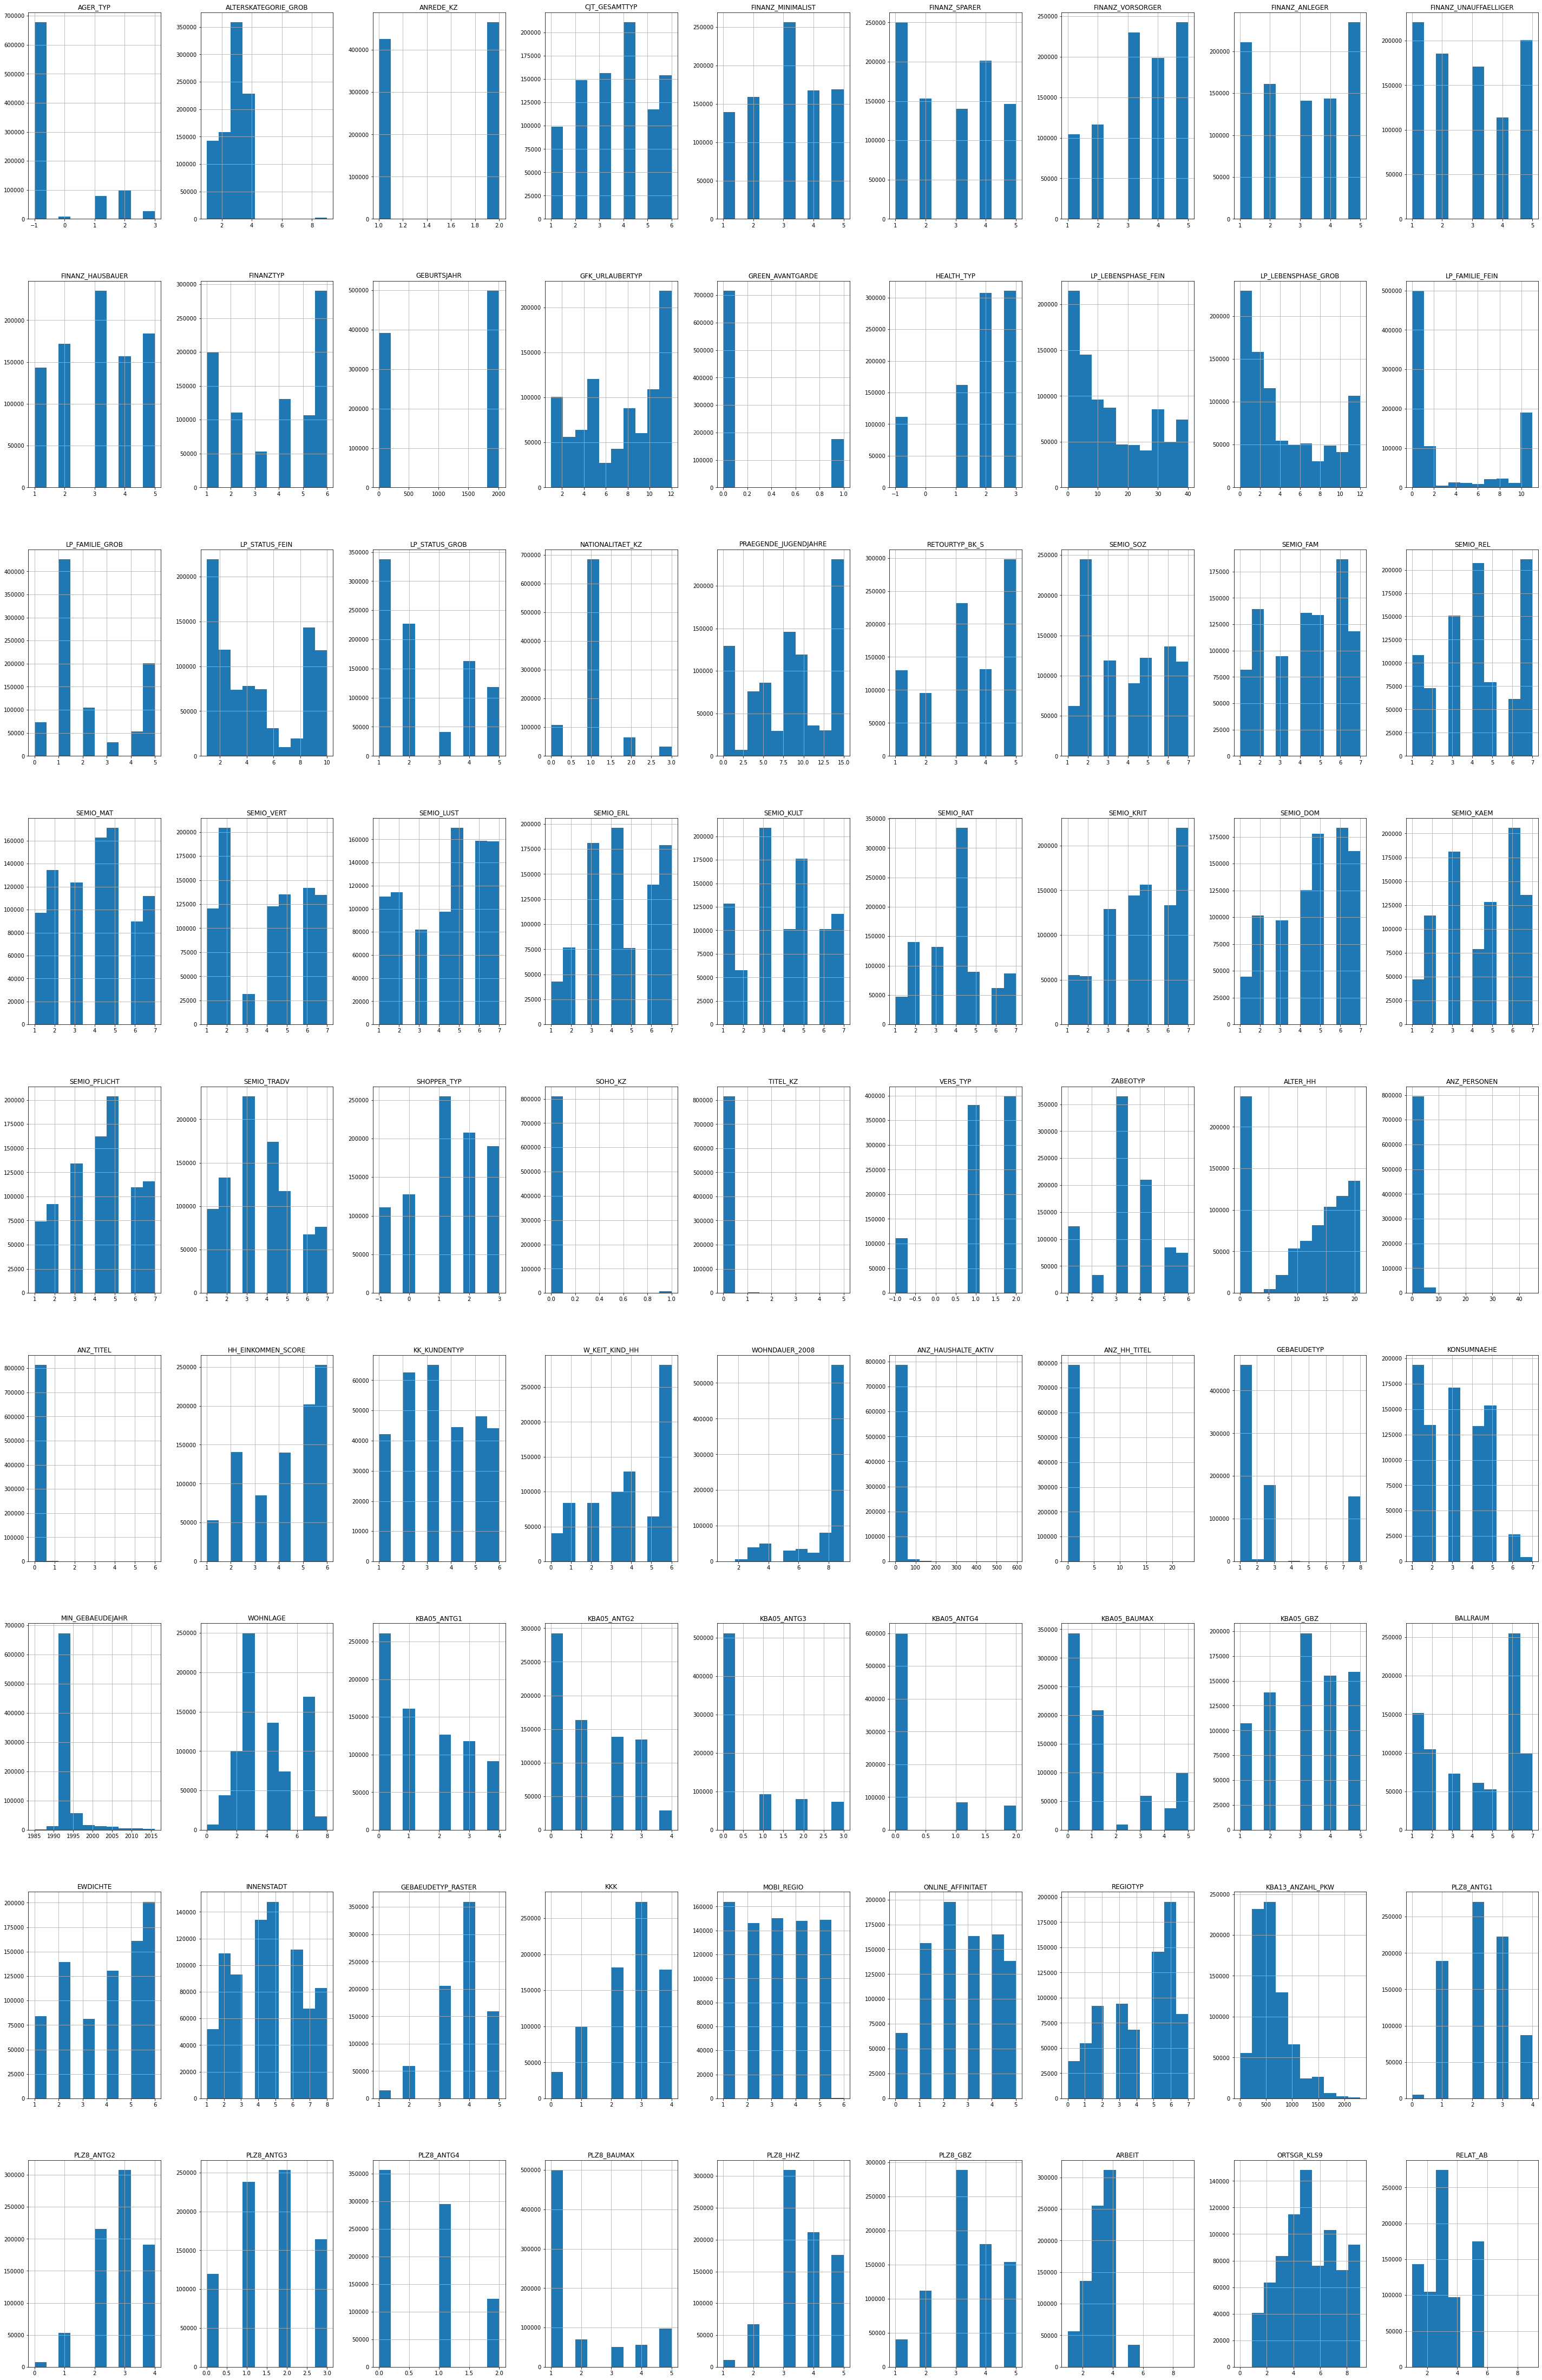

In [8]:
# Take a look at the data distributed in each column
azdias.hist(figsize=(50,80));

In [9]:
# Statistical look at the data
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [11]:
feat_info.shape

(85, 4)

In [12]:
# Take a look at the "Data_Dictionary" file, which details the data and files we have.
f = open('Data_Dictionary.md')
for a in f:
    print(a)

# Data Dictionary for Identify Customer Segments Data



## Introduction



The data for this project consist of two files:



- Udacity_AZDIAS_Subset.csv: demographics data for the general population of

      Germany; 891211 persons (rows) x 85 features (columns)

- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order

      company; 191652 persons (rows) x 85 features (columns)



The columns in the general demographics file and customers data file are the

same. This file documents the features that appear in the data files, sorted in

order of appearance. Sections of this file is based on the level of measurement

of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of

feature attributes, including information level, data type, and codes for

missing or unknown values.



### Table of Contents



 1. Person-level features

 2. Household-level features

 3. Building-level features

 4. RR4 micro-cell features

 5. RR3 micro-cell featur

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# Identify missing or unknown data values and convert them to NaNs.

In [14]:
# Number of missing values for each column
Na = azdias.isna().sum()
Na

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [15]:
# Total missing values
total_Na = Na.sum()
total_Na

4896838

In [16]:
# Dataframe for NaN
df_Na = pd.DataFrame(Na)
df_Na.head()

,0
AGER_TYP,0
ALTERSKATEGORIE_GROB,0
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0


In [17]:
# Take a look at the data features
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


#####  we have additional missing data referenced in each column in a specific way, so we will deal with it
##### We also have a description of the data sections and categories, which will help us in evaluating them later

In [18]:
# Given the way we will deal with "missing_or_unknown" column , therefore, we will define unique values in it

In [19]:
# looking for the unique values of feat_info['missing_or_unknown']
set_ = set()
for a in feat_info['missing_or_unknown'].values:
    for b in set(a):
        set_.add(b)
set_

{',', '-', '0', '1', '9', 'X', '[', ']'}

In [20]:
# Therefore, we need to deal with any 'X' hear

In [21]:
# In addition to the missing data that we calculated earlier,
# we will calculate the data expressed as missing_or_unknown data according to the feat_info file.
dic_Nan = {}
for i,a in enumerate(zip(azdias.columns,feat_info['missing_or_unknown'])):
    # a[0] name of column
    # a[1] Is the symbol that indicates missing data according to feat_info for each column
    col = azdias[a[0]]
    missing_values = a[1]
    X = 'X'
    XX = 'XX'
    Nan = eval(missing_values)
    # Count the number of appearances of unknown values in each column and record them in dict
    dic_Nan[a[0]] = sum(col.isin(Nan))

In [22]:
dic_Nan

{'AGER_TYP': 685843,
 'ALTERSKATEGORIE_GROB': 2881,
 'ANREDE_KZ': 0,
 'CJT_GESAMTTYP': 0,
 'FINANZ_MINIMALIST': 0,
 'FINANZ_SPARER': 0,
 'FINANZ_VORSORGER': 0,
 'FINANZ_ANLEGER': 0,
 'FINANZ_UNAUFFAELLIGER': 0,
 'FINANZ_HAUSBAUER': 0,
 'FINANZTYP': 0,
 'GEBURTSJAHR': 392318,
 'GFK_URLAUBERTYP': 0,
 'GREEN_AVANTGARDE': 0,
 'HEALTH_TYP': 111196,
 'LP_LEBENSPHASE_FEIN': 92778,
 'LP_LEBENSPHASE_GROB': 89718,
 'LP_FAMILIE_FEIN': 72938,
 'LP_FAMILIE_GROB': 72938,
 'LP_STATUS_FEIN': 0,
 'LP_STATUS_GROB': 0,
 'NATIONALITAET_KZ': 108315,
 'PRAEGENDE_JUGENDJAHRE': 108164,
 'RETOURTYP_BK_S': 0,
 'SEMIO_SOZ': 0,
 'SEMIO_FAM': 0,
 'SEMIO_REL': 0,
 'SEMIO_MAT': 0,
 'SEMIO_VERT': 0,
 'SEMIO_LUST': 0,
 'SEMIO_ERL': 0,
 'SEMIO_KULT': 0,
 'SEMIO_RAT': 0,
 'SEMIO_KRIT': 0,
 'SEMIO_DOM': 0,
 'SEMIO_KAEM': 0,
 'SEMIO_PFLICHT': 0,
 'SEMIO_TRADV': 0,
 'SHOPPER_TYP': 111196,
 'SOHO_KZ': 0,
 'TITEL_KZ': 815562,
 'VERS_TYP': 111196,
 'ZABEOTYP': 0,
 'ALTER_HH': 236768,
 'ANZ_PERSONEN': 0,
 'ANZ_TITEL': 0,
 'HH_

In [23]:
# Unknown and missing values according to feat_info
total_Nan = sum(dic_Nan.values())
total_Nan

3477091

In [24]:
# We will make a Datafram and serice for the missing data in the first place, and the missing data according to  “feat_info” file , to make comparison and addition
S_Nan = pd.Series(dic_Nan)
S_Nan.head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP                0
FINANZ_MINIMALIST            0
dtype: int64

In [25]:
Na.head()

AGER_TYP                   0
ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
dtype: int64

In [26]:
df_Nan = pd.concat([Na,S_Nan],axis=1)
df_Nan.head()

,0,1
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,0
FINANZ_MINIMALIST,0,0


In [27]:
#Add a column for the total of missing values in the first place expressed as "Nan", and those expressed in the 'feat_info' file
df_Nan['sum'] = df_Nan[0] + df_Nan[1]
df_Nan.head(20)

,0,1,sum
AGER_TYP,0,685843,685843
ALTERSKATEGORIE_GROB,0,2881,2881
ANREDE_KZ,0,0,0
CJT_GESAMTTYP,4854,0,4854
FINANZ_MINIMALIST,0,0,0
FINANZ_SPARER,0,0,0
FINANZ_VORSORGER,0,0,0
FINANZ_ANLEGER,0,0,0
FINANZ_UNAUFFAELLIGER,0,0,0
FINANZ_HAUSBAUER,0,0,0


In [28]:
# missing , unknown and Nans values in total at the end
new_total_Nan = df_Nan['sum'].sum()
new_total_Nan

8373929

In [29]:
# Identify missing or unknown data values and convert them to NaNs.

for i,a in enumerate(zip(azdias.columns,feat_info['missing_or_unknown'])):
    s = azdias[a[0]]
    X = 'X'
    XX = 'XX'
    Nan = eval(a[1])
    if len(Nan) == 0: continue
    azdias[a[0]].replace(Nan, np.nan ,inplace=True)

In [30]:
azdias.isna().sum()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

In [31]:
azdias.isna().sum().sum()

8373929

In [32]:
# To ensure that the sum of the missing values now after conversion is the same as the sum that was previously calculated
sum(azdias.isna().sum() == df_Nan['sum'])

85

In [33]:
# It's true for every column, so we have the number 85

In [34]:
# Or we match that way
azdias.isna().sum().sum() == df_Nan['sum'].sum()

True

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [35]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = pd.DataFrame(df_Nan['sum'])
missing_data = missing_data.rename(columns={'sum':'total_of_missing_data'})
missing_data

,total_of_missing_data
AGER_TYP,685843
ALTERSKATEGORIE_GROB,2881
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0
...,...
PLZ8_HHZ,116515
PLZ8_GBZ,116515
ARBEIT,97375
ORTSGR_KLS9,97274


In [36]:
missing_data[missing_data['total_of_missing_data'] < (0.15 * azdias.shape[0])].shape[0]

76

In [37]:
# The largest percentage of columns have no missing data that exceeds 15% of the number of rows.

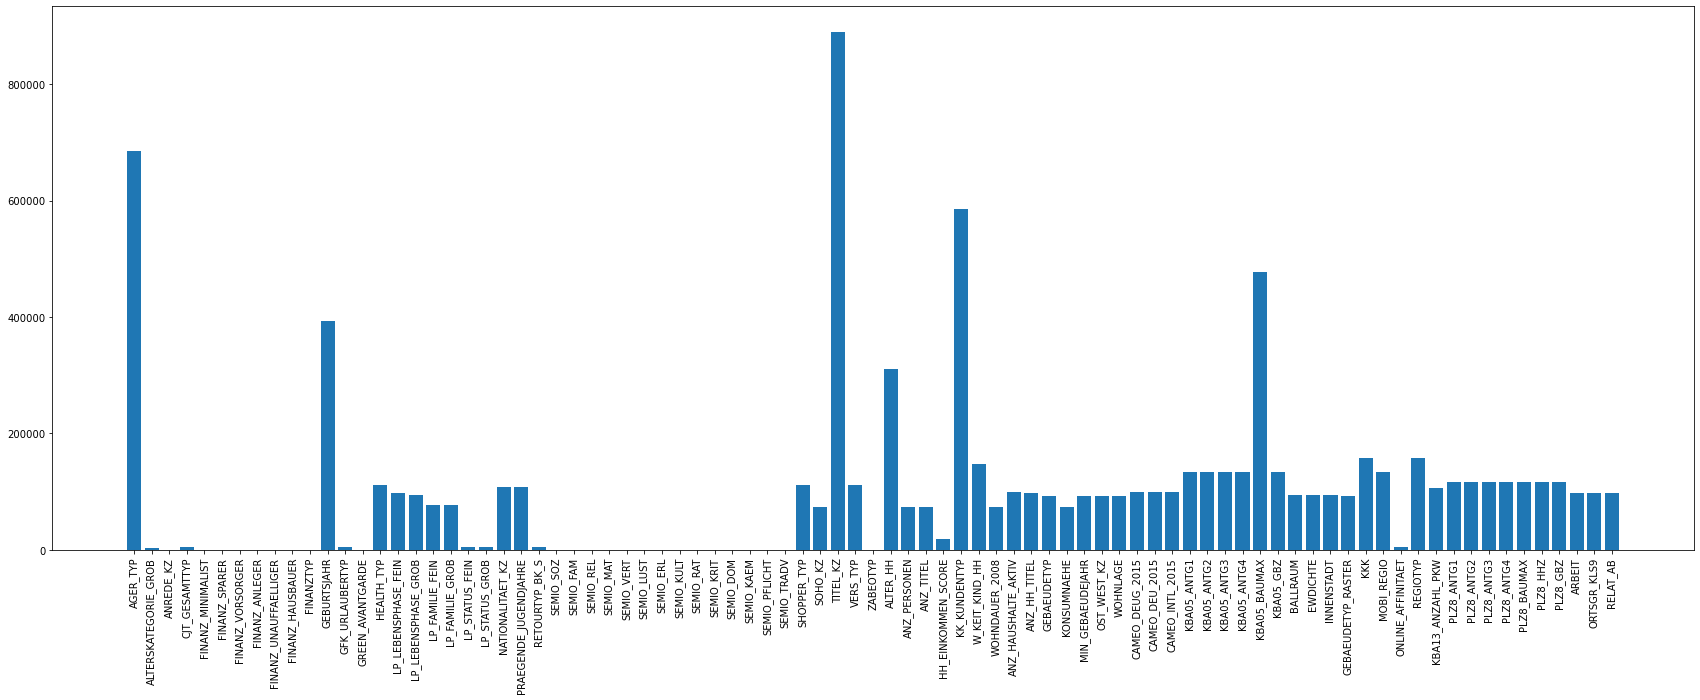

In [38]:
# Investigate patterns in the amount of missing data in each column.

column = list(missing_data.index)
missing = list(df_Nan['sum'])

plt.figure(figsize=(100, 10))

plt.subplot(131)
plt.bar(column, missing)
plt.xticks(rotation=90)
plt.show()

# sorce:
# https://matplotlib.org/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py
#https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib

In [39]:
patterns = missing_data.groupby(by='total_of_missing_data')

In [40]:
patterns.groups

{0: ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP'], 2881: ['ALTERSKATEGORIE_GROB'], 4854: ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET'], 18348: ['HH_EINKOMMEN_SCORE'], 73499: ['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008'], 73969: ['KONSUMNAEHE'], 77792: ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB'], 93148: ['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE'], 93155: ['GEBAEUDETYP_RASTER'], 93740: ['BALLRAUM', 'EWDICHTE', 'INNENSTADT'], 94572: ['LP_LEBENSPHASE_GROB'], 97008: ['ANZ_HH_TITEL'], 97274: ['ORTSGR_KLS9'], 97375: ['ARBEIT', 'RELAT_AB'], 97632: ['LP_LEBENSPHASE_FEIN'], 99352: ['

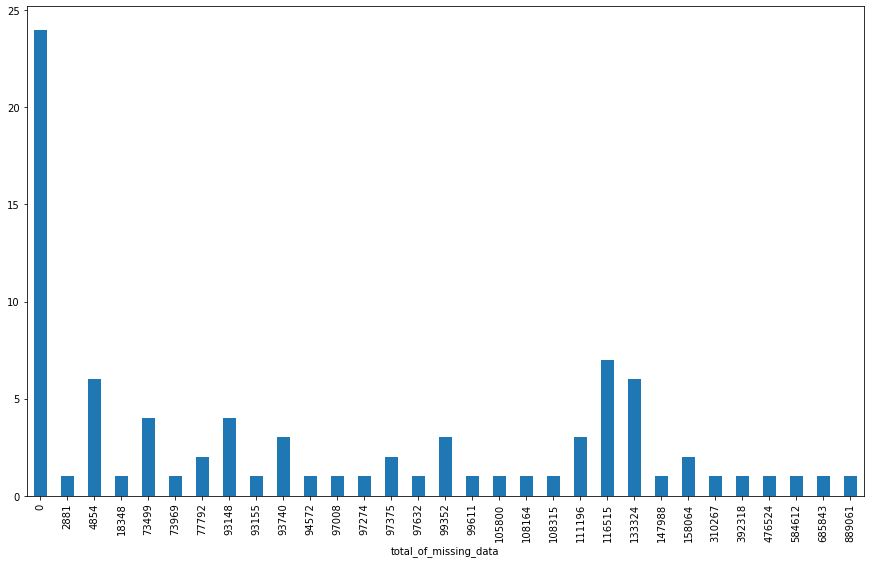

In [41]:
patterns.size().plot.bar(figsize=(15,9));

In [42]:
# Here we see groups, we find that in more than one case, a number of columns correspond to a certain value of the missing dataو 
# and this is an observation that may have a certain significance.

# Another observation is that the largest group,
# is the group that does not have any missing data, and it amounts to 24 columns

In [43]:
dic_patterns = {}
for k,v in patterns.groups.items():
    dic_patterns[k]= v.values
dic_patterns

{0: array(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
        'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
        'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ',
        'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
        'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
        'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP'],
       dtype=object),
 2881: array(['ALTERSKATEGORIE_GROB'], dtype=object),
 4854: array(['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET'],
       dtype=object),
 18348: array(['HH_EINKOMMEN_SCORE'], dtype=object),
 73499: array(['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008'],
       dtype=object),
 73969: array(['KONSUMNAEHE'], dtype=object),
 77792: array(['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB'], dtype=object),
 93148: array(['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE'],
  

In [44]:
df_patterns = pd.Series(dic_patterns)
df_patterns = pd.DataFrame(df_patterns)
df_patterns = df_patterns.reset_index()
df_patterns = df_patterns.rename(columns={'index':'Nan',0:'columns_of_same_Nan'})
df_patterns

,Nan,columns_of_same_Nan
0,0,"[ANREDE_KZ, FINANZ_MINIMALIST, FINANZ_SPARER, ..."
1,2881,[ALTERSKATEGORIE_GROB]
2,4854,"[CJT_GESAMTTYP, GFK_URLAUBERTYP, LP_STATUS_FEI..."
3,18348,[HH_EINKOMMEN_SCORE]
4,73499,"[SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2..."
5,73969,[KONSUMNAEHE]
6,77792,"[LP_FAMILIE_FEIN, LP_FAMILIE_GROB]"
7,93148,"[GEBAEUDETYP, MIN_GEBAEUDEJAHR, OST_WEST_KZ, W..."
8,93155,[GEBAEUDETYP_RASTER]
9,93740,"[BALLRAUM, EWDICHTE, INNENSTADT]"


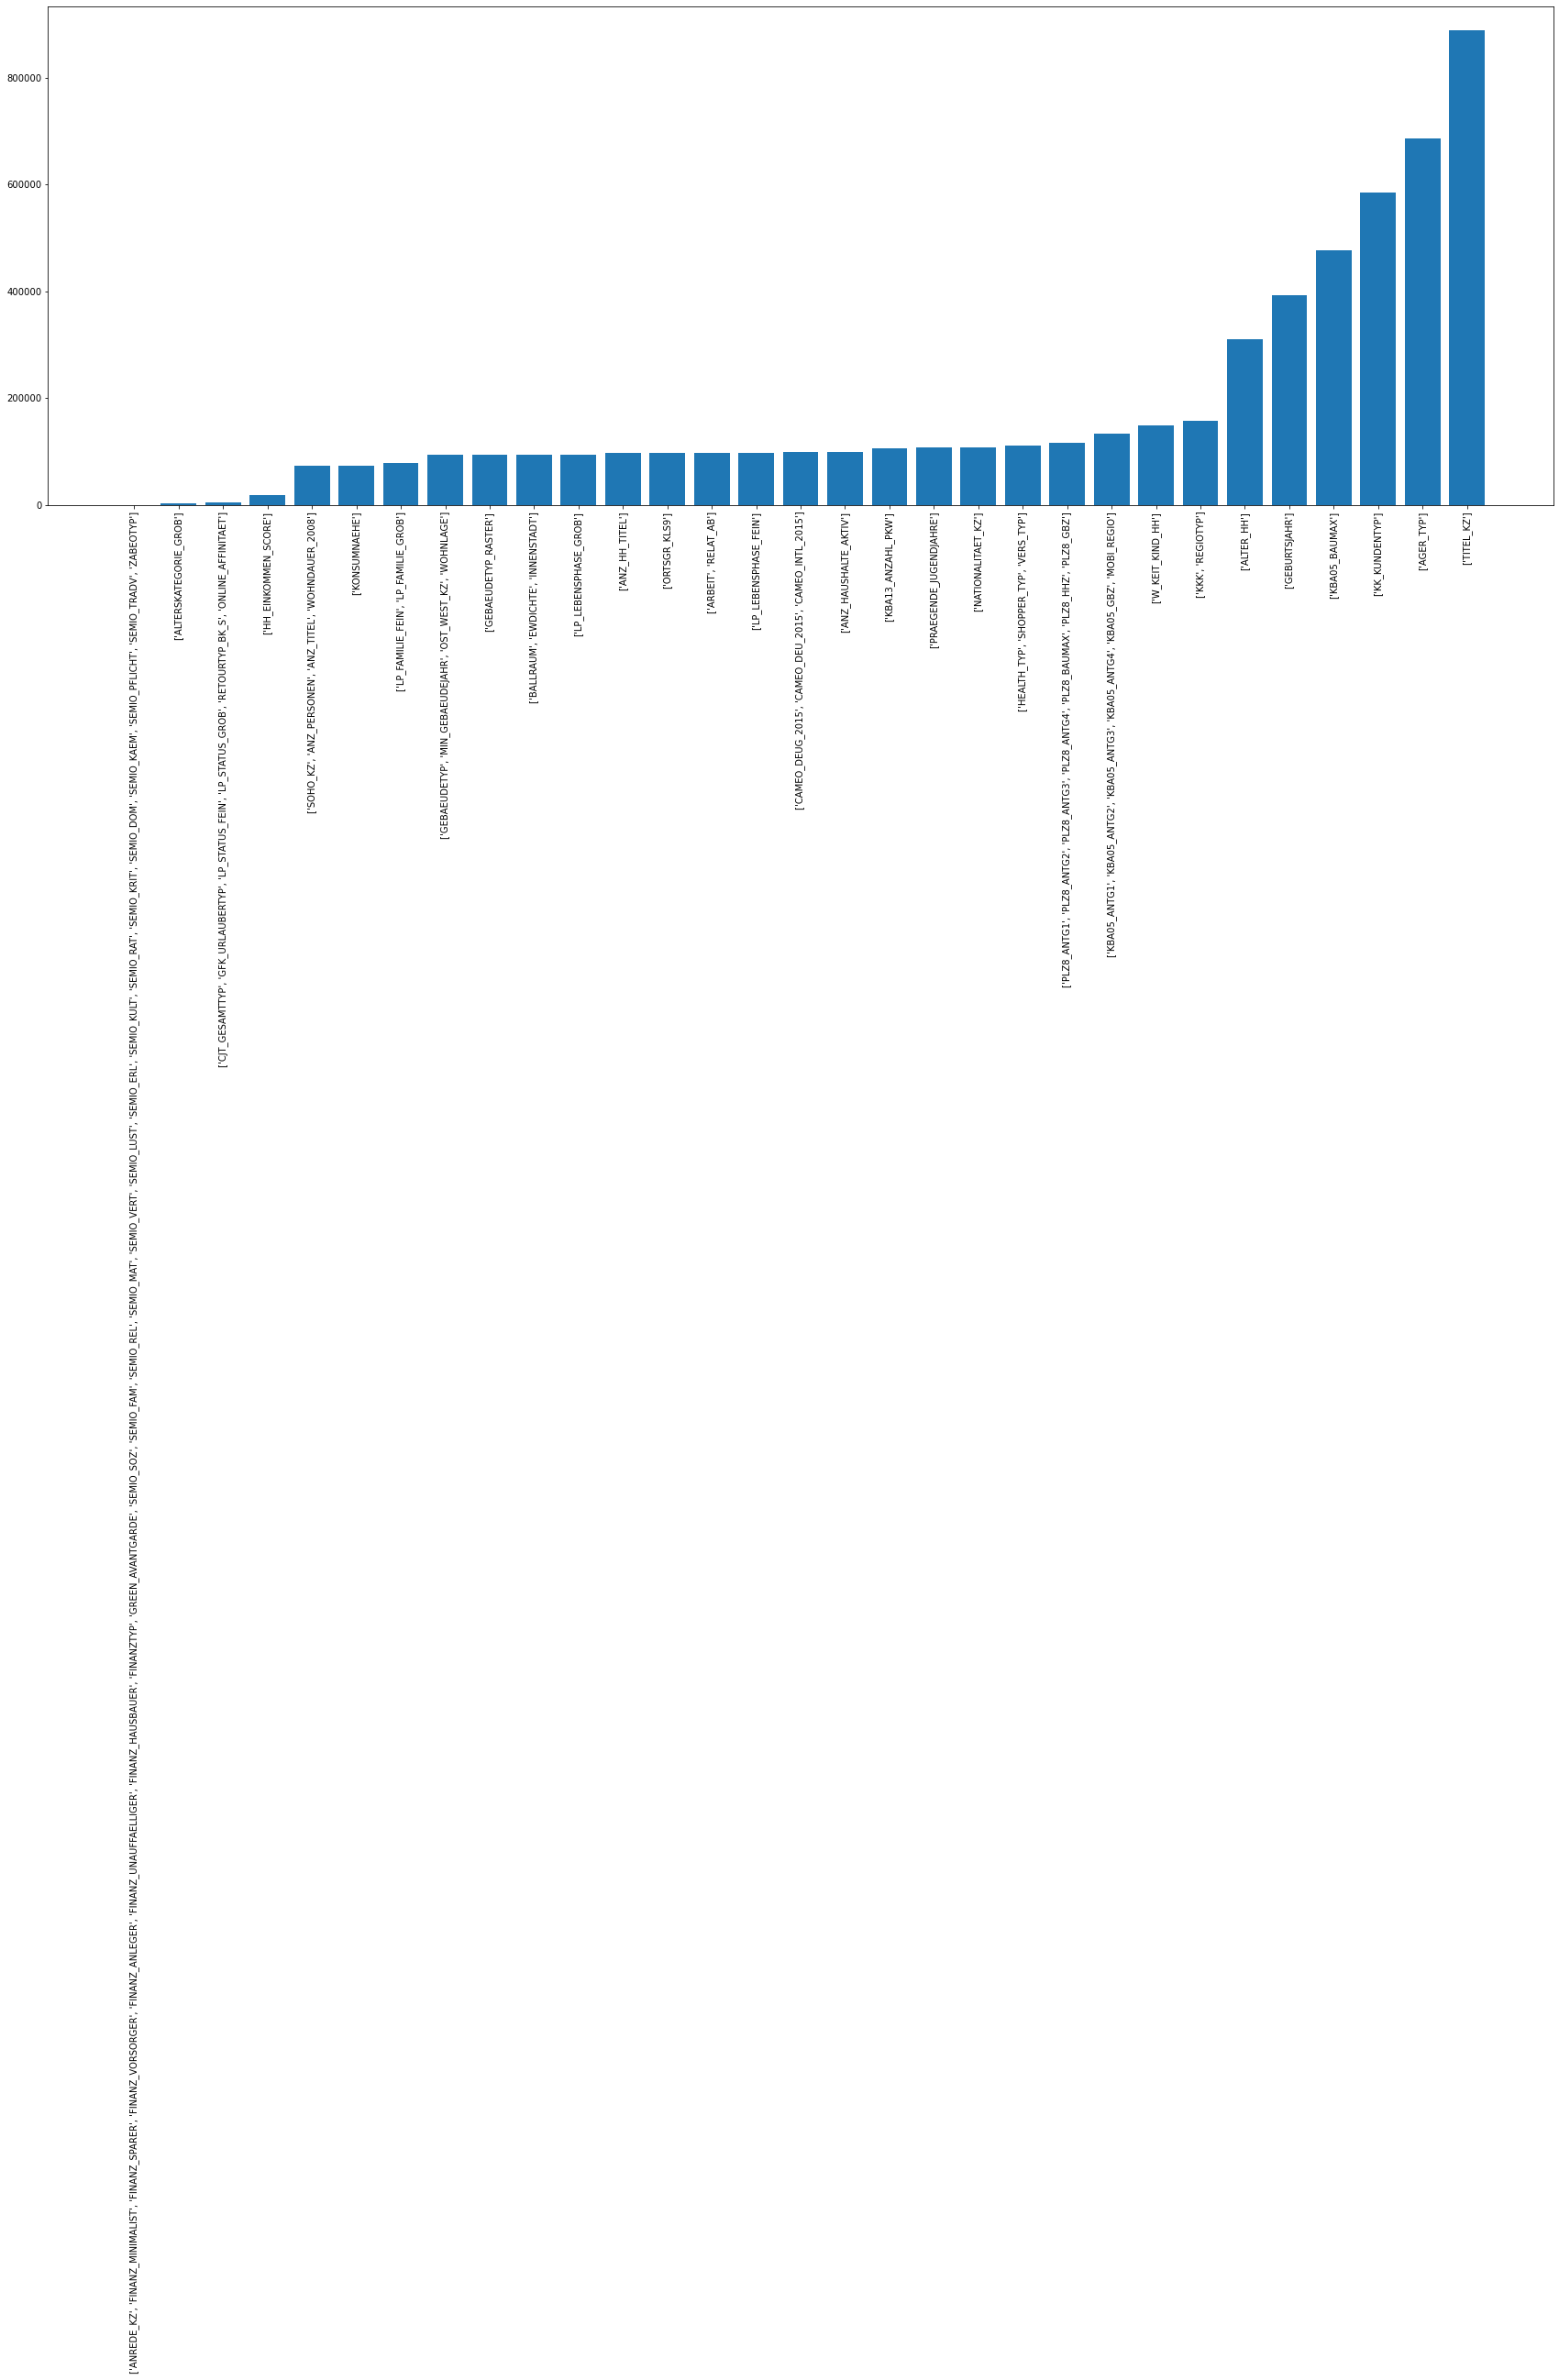

In [45]:
groups = [str(list(a)) for a in df_patterns['columns_of_same_Nan']]
num_Nan = [b for b in df_patterns['Nan']]

plt.figure(figsize=(100, 10))

plt.subplot(131)
plt.bar(groups, num_Nan)
plt.xticks(rotation=90)
plt.show()


In [46]:
# Here we see the column groups with their names,
# for each specific value of the missing data in the column

# We also see that there are columns with hundreds of thousands of missing data,
# which is a large number relative to the rows,
# which are approximately 900,000 rows.

In [47]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
out_lier = df_patterns[df_patterns['Nan'] > 160000]
out_lier

,Nan,columns_of_same_Nan
25,310267,[ALTER_HH]
26,392318,[GEBURTSJAHR]
27,476524,[KBA05_BAUMAX]
28,584612,[KK_KUNDENTYP]
29,685843,[AGER_TYP]
30,889061,[TITEL_KZ]


In [48]:
# We'll exclude columns with more than 160,000 missing data

In [49]:
out_lier.columns_of_same_Nan

25        [ALTER_HH]
26     [GEBURTSJAHR]
27    [KBA05_BAUMAX]
28    [KK_KUNDENTYP]
29        [AGER_TYP]
30        [TITEL_KZ]
Name: columns_of_same_Nan, dtype: object

In [50]:
list_out_lier = [list(a)[0] for a in out_lier['columns_of_same_Nan']]
list_out_lier

['ALTER_HH',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'AGER_TYP',
 'TITEL_KZ']

In [51]:
azdias.drop(list_out_lier, axis=1, inplace=True)

In [52]:
azdias.shape[1]

79

In [53]:
df_patterns

,Nan,columns_of_same_Nan
0,0,"[ANREDE_KZ, FINANZ_MINIMALIST, FINANZ_SPARER, ..."
1,2881,[ALTERSKATEGORIE_GROB]
2,4854,"[CJT_GESAMTTYP, GFK_URLAUBERTYP, LP_STATUS_FEI..."
3,18348,[HH_EINKOMMEN_SCORE]
4,73499,"[SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2..."
5,73969,[KONSUMNAEHE]
6,77792,"[LP_FAMILIE_FEIN, LP_FAMILIE_GROB]"
7,93148,"[GEBAEUDETYP, MIN_GEBAEUDEJAHR, OST_WEST_KZ, W..."
8,93155,[GEBAEUDETYP_RASTER]
9,93740,"[BALLRAUM, EWDICHTE, INNENSTADT]"


In [54]:
# We'll take a look after we delete the columns that most contain the missing data

In [55]:
df_patterns_2 = df_patterns[df_patterns['Nan'] < 160000]
df_patterns_2

,Nan,columns_of_same_Nan
0,0,"[ANREDE_KZ, FINANZ_MINIMALIST, FINANZ_SPARER, ..."
1,2881,[ALTERSKATEGORIE_GROB]
2,4854,"[CJT_GESAMTTYP, GFK_URLAUBERTYP, LP_STATUS_FEI..."
3,18348,[HH_EINKOMMEN_SCORE]
4,73499,"[SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2..."
5,73969,[KONSUMNAEHE]
6,77792,"[LP_FAMILIE_FEIN, LP_FAMILIE_GROB]"
7,93148,"[GEBAEUDETYP, MIN_GEBAEUDEJAHR, OST_WEST_KZ, W..."
8,93155,[GEBAEUDETYP_RASTER]
9,93740,"[BALLRAUM, EWDICHTE, INNENSTADT]"


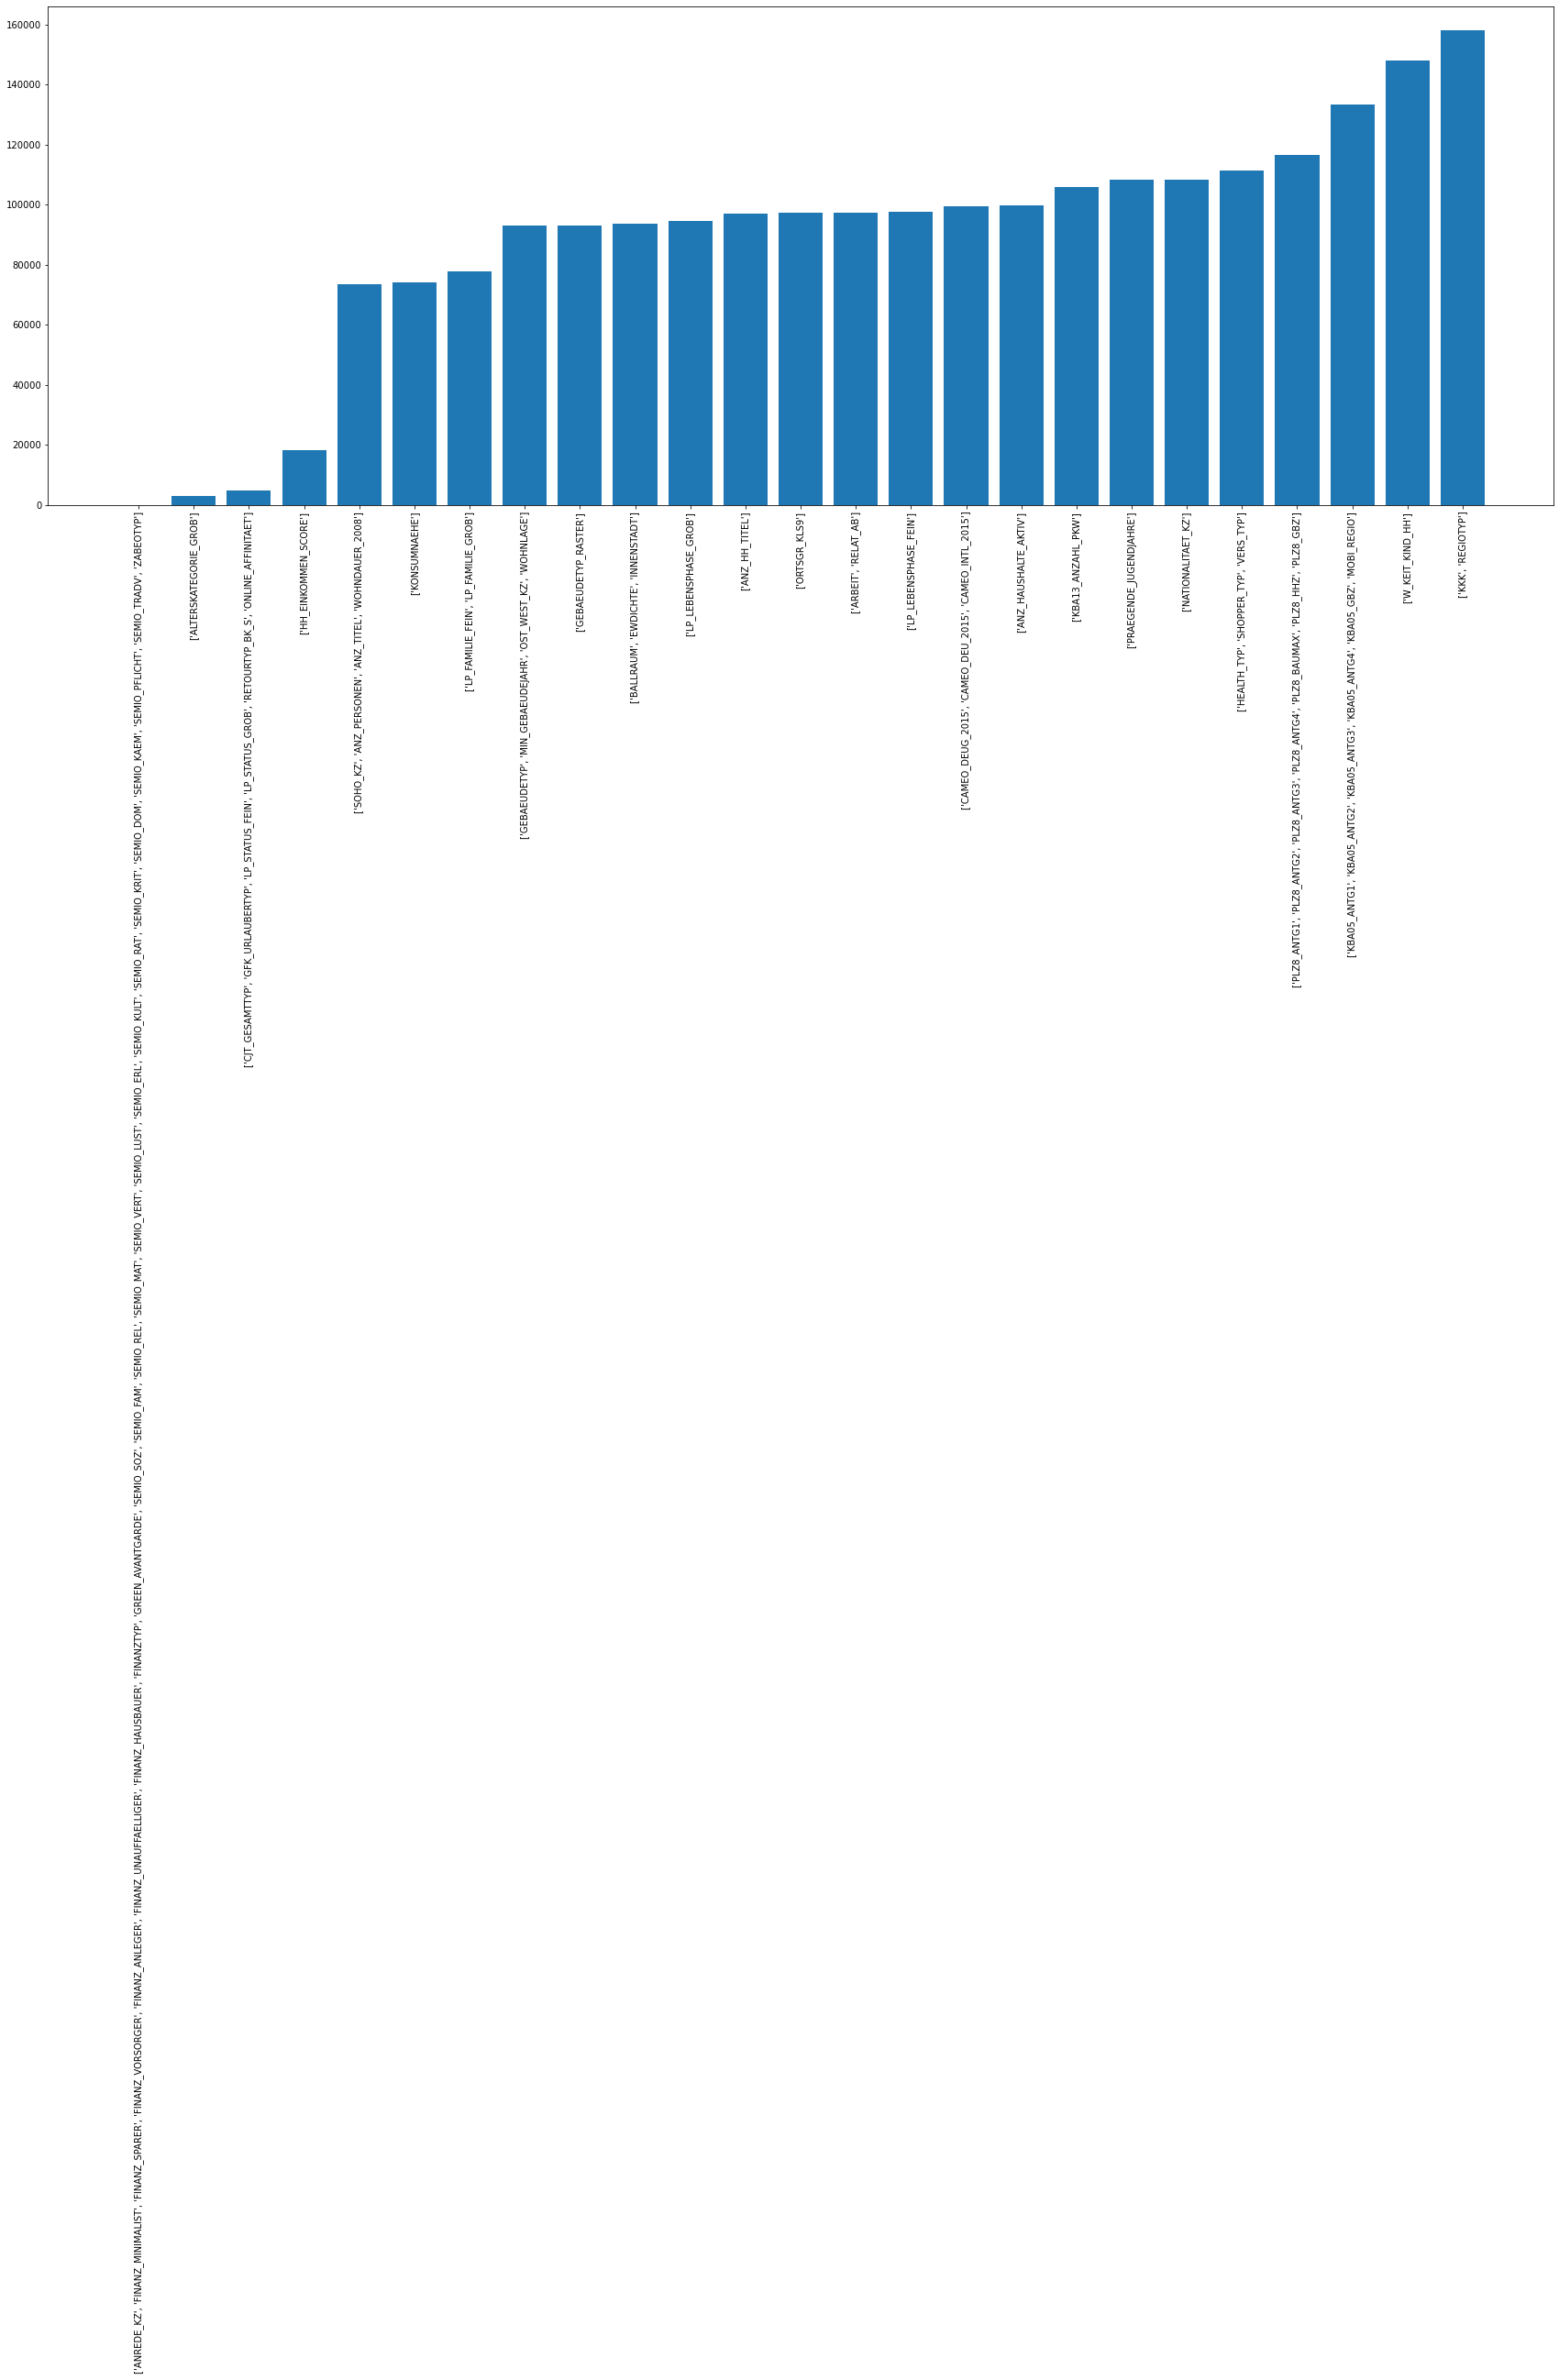

In [56]:
groups = [str(list(a)) for a in df_patterns_2['columns_of_same_Nan']]
num_Nan = [b for b in df_patterns_2['Nan']]

plt.figure(figsize=(100, 10))

plt.subplot(131)
plt.bar(groups, num_Nan)
plt.xticks(rotation=90)
plt.show()


In [57]:
missing_data_2 = missing_data.drop(index=list_out_lier)

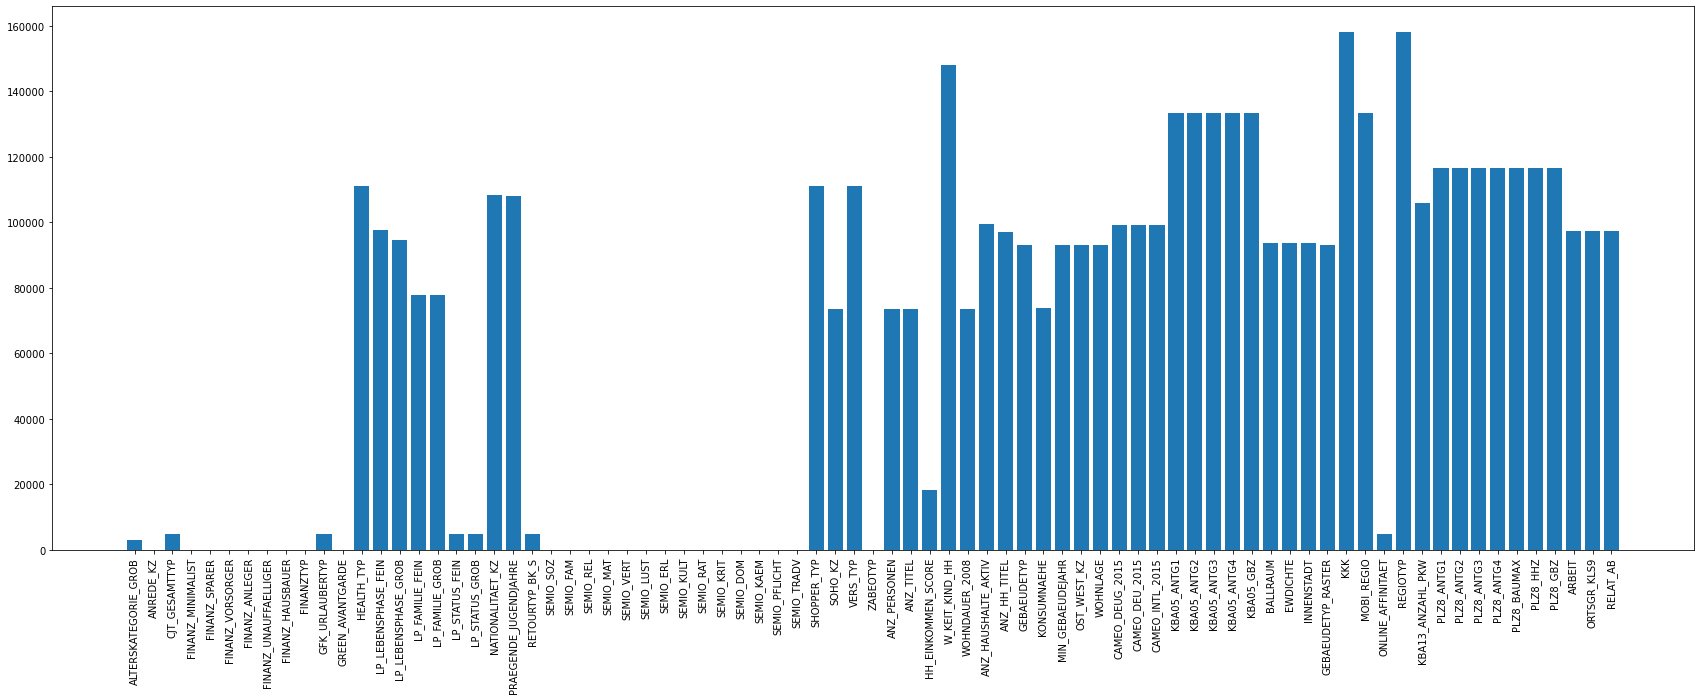

In [58]:
column = list(missing_data_2.index)
missing = list(missing_data_2['total_of_missing_data'])

plt.figure(figsize=(100, 10))

plt.subplot(131)
plt.bar(column, missing)
plt.xticks(rotation=90)
plt.show()


In [59]:
# After we deleted the columns that contain the most missing data, the graph,
# which shows the number of missing data for each column, looks closer and clearer.
# also, Obviously, some of the columns in the missing data are quite equal

#### Discussion 1.1.2: Assess Missing Data in Each Column

### There are a small number of columns that contain a large number of missing data, on the other hand, the largest fraction of columns have no missing data. The largest part after that contains missing data that does not exceed 15% of the number of rows.

### There is a clear pattern of missing data, as we have columns that correspond exactly to the amount of missing data.

### We have deleted the following six columns, in which the lost data exceeds 160K

['ALTER_HH',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'AGER_TYP',
 'TITEL_KZ']

In [60]:
list_out_lier

['ALTER_HH',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'AGER_TYP',
 'TITEL_KZ']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [61]:
# Total Nan in whole dataset until now
total_Nan_3 = azdias.isna().sum(axis=1).sum()
total_Nan_3

5035304

In [62]:
# How much data is missing in each row of the dataset?
total_Nan_in_rows = azdias.isna().sum(axis=1)
total_Nan_in_rows

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [63]:
total_Nan_in_rows.rename('Nan')

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Name: Nan, Length: 891221, dtype: int64

In [64]:
# group of rows by total Nan
group_rows = total_Nan_in_rows.groupby(by=total_Nan_in_rows)
group_rows.indices

{0: array([     1,      2,      4, ..., 891215, 891219, 891220], dtype=int64),
 1: array([    72,    195,    213, ..., 890995, 891009, 891079], dtype=int64),
 2: array([    29,     42,     80, ..., 891111, 891114, 891136], dtype=int64),
 3: array([    18,     92,     94, ..., 891181, 891208, 891216], dtype=int64),
 4: array([    34,     40,     60, ..., 891155, 891157, 891217], dtype=int64),
 5: array([    25,     39,     64, ..., 890908, 891128, 891218], dtype=int64),
 6: array([    12,     16,    197, ..., 891115, 891135, 891162], dtype=int64),
 7: array([     3,     70,    159, ..., 890852, 890938, 891139], dtype=int64),
 8: array([    13,     15,     23, ..., 891112, 891129, 891184], dtype=int64),
 9: array([   272,    543,    641, ..., 890887, 890927, 890982], dtype=int64),
 10: array([    20,    184,    255, ..., 890367, 890485, 890903], dtype=int64),
 11: array([   456,   1008,   1621, ..., 889975, 891032, 891154], dtype=int64),
 12: array([  2224,   2933,   6391,   7020,   8180

In [65]:
group_rows.size()

0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64

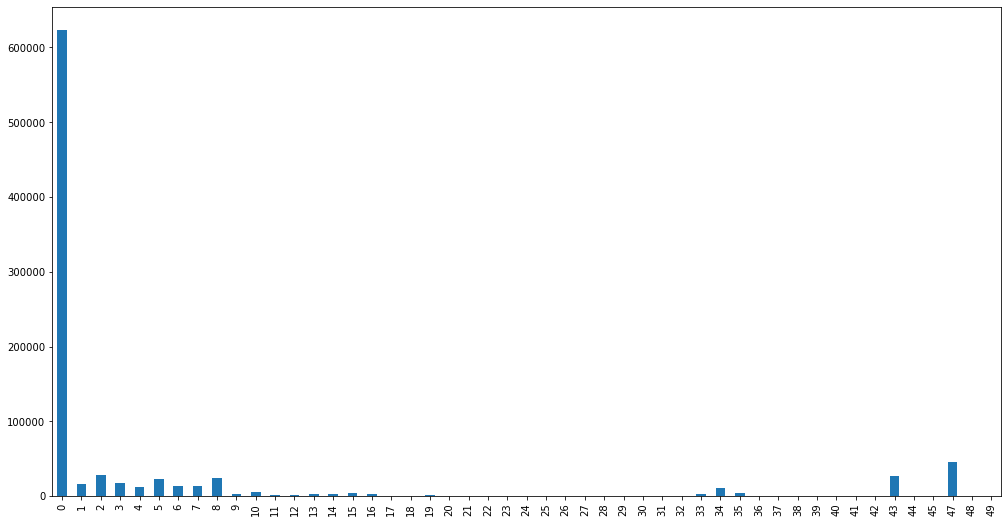

In [66]:
group_rows.size().plot.bar(figsize=(17,9));

In [67]:
group_rows.size()[0]

623209

In [68]:
# As it is clear, the largest part of the rows does not contain any missing data
# more than 623 thousand rows, or more than 65% of them.

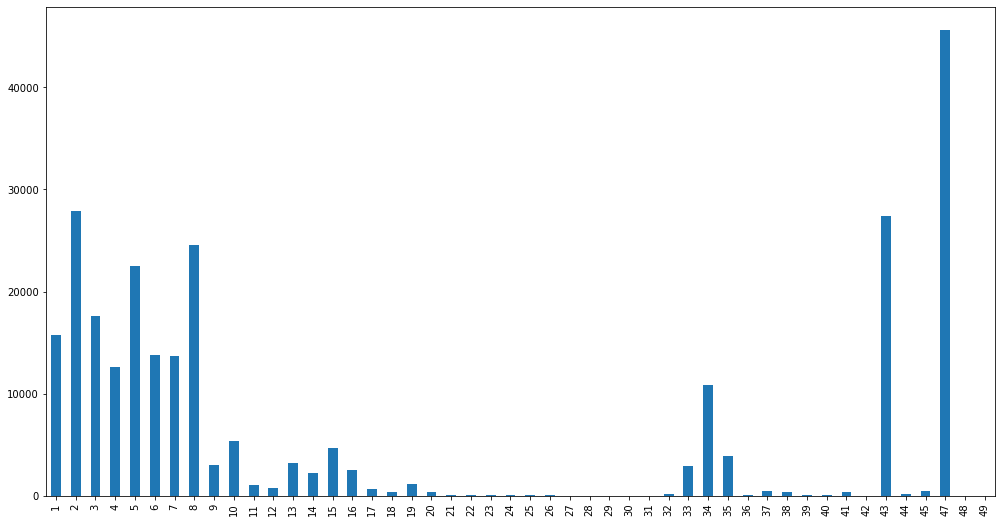

In [69]:
#To get a closer look at the pattern of missing data in rows,
# we will ignore the larger group that does not contain any missing data.

# skip rows with Nan's = 0
group_rows.size()[1:].plot.bar(figsize=(17,9));

In [70]:
# As it seems, the graph shows that the rows are divided into two parts,
# rows with missing values of a quantity of 20 and less,
# and rows with missing values of a quantity of 32 and more.

In [71]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.


In [72]:
azdias.shape

(891221, 79)

In [73]:
rows = azdias.shape[0]
col = azdias.shape[1]
print(rows, col)

891221 79


In [74]:
# We will divide the data into two parts,
# the first section contains missing values that do not exceed 60%,
# and the second section contains missing values that exceed 60%

In [75]:
azdias.shape[1]*0.6

47.4

In [76]:
int(col*0.6)

47

In [77]:
Thresh = int(col*0.6)
azdias_min_Nan = azdias.dropna(thresh=Thresh)
azdias_min_Nan.shape

(798276, 79)

In [78]:
azdias['total_Nan_in_rows'] = total_Nan_in_rows
azdias

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,total_Nan_in_rows
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN,3
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0,4
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0,5
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0,0


In [79]:
col - Thresh

32

In [80]:
azdias_max_Nan = azdias[azdias.total_Nan_in_rows > (col - Thresh) ]
azdias_max_Nan

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,total_Nan_in_rows
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891164,3.0,2,4.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
891171,3.0,2,5.0,4,2,3,5,5,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
891175,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
891185,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47


In [81]:
# to be shore that our data split in right way
azdias.shape[0] == (azdias_min_Nan.shape[0] + azdias_max_Nan.shape[0])

True

In [82]:
azdias.shape[0]

891221

In [83]:
azdias_min_Nan.shape[0] + azdias_max_Nan.shape[0]

891221

In [84]:
azdias_min_Nan.shape[0]

798276

In [85]:
azdias_max_Nan.shape[0]

92945

In [86]:
azdias.drop(columns=['total_Nan_in_rows'], inplace=True)
azdias_max_Nan.drop(columns=['total_Nan_in_rows'], inplace=True)

C:\Users\abjan\anaconda3\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [87]:
# Check to be shore
azdias.shape[1] and azdias_max_Nan.shape[1] == col

True

In [88]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [89]:
# We will collect seven columns that do not contain any missing values
col_non_Nan = list()
for  i,col in enumerate(dic_patterns[0]):
    col_non_Nan.append(col)
    if i==6: break
        
col_non_Nan

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER']

In [90]:
# We will look at the distribution of data for these columns between the two groups,

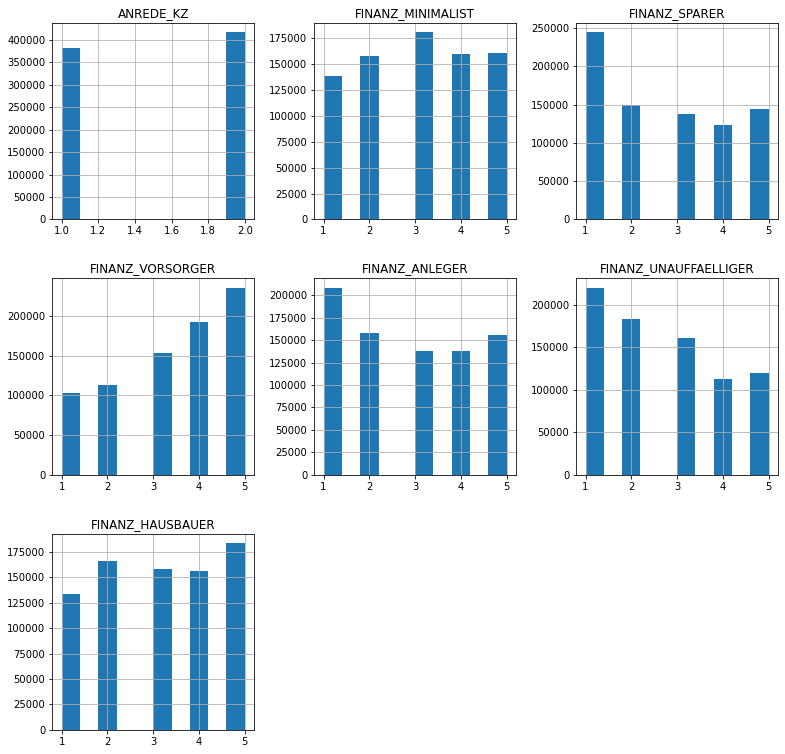

In [91]:
# the first group, is the group of rows with the lowest percentage of missing values
azdias_min_Nan[col_non_Nan].hist(figsize=(13,13));

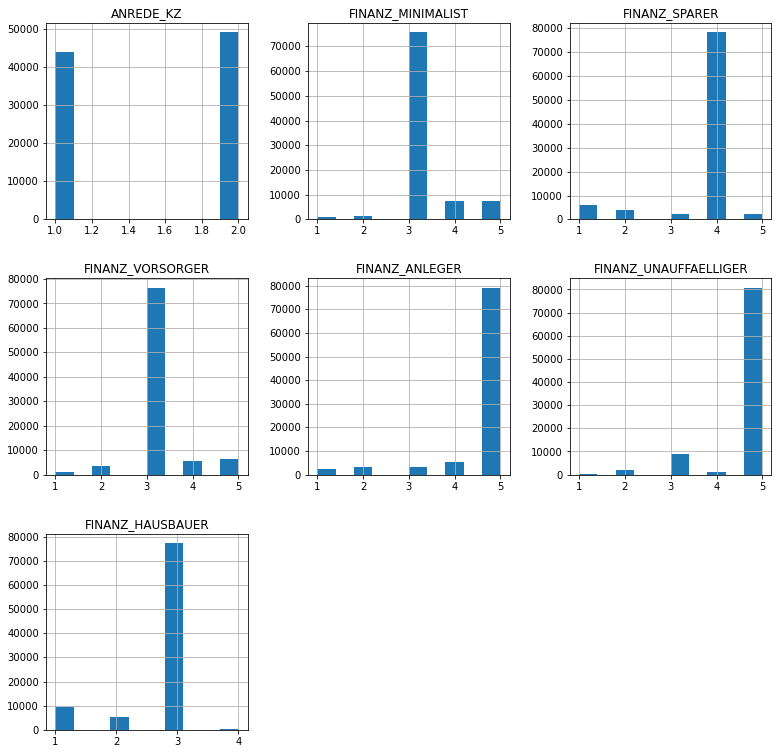

In [92]:
# Now we look at the distribution of the data in the second group,
# which is the group of rows with a high percentage of missing values
azdias_max_Nan[col_non_Nan].hist(figsize=(13,13));

In [93]:
# We clearly see a wide difference in the data distribution between the two groups

In [94]:
azdias_max_Nan[col_non_Nan]

,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER
0,1,3,4,3,5,5,3
11,1,3,4,3,5,5,3
14,1,3,4,3,5,5,3
17,1,3,4,3,5,5,3
24,2,3,4,3,5,5,3
...,...,...,...,...,...,...,...
891164,2,3,4,3,5,5,3
891171,2,4,2,3,5,5,1
891175,2,3,4,3,5,5,3
891185,1,3,4,3,5,5,3


In [95]:
azdias_min_Nan[col_non_Nan]

,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER
1,2,1,5,2,5,4,5
2,2,1,4,1,2,3,5
3,2,4,2,5,2,1,2
4,1,4,3,4,1,3,2
5,2,3,1,5,2,2,5
...,...,...,...,...,...,...,...
891216,2,1,4,2,5,4,4
891217,1,3,3,3,2,2,3
891218,2,2,4,2,5,4,3
891219,1,1,5,3,5,5,5


In [96]:
dis_max_nan = list()
dis_min_nan = list()
for a in col_non_Nan:
    dis_max_nan.append(azdias_max_Nan[a].groupby(by=azdias_max_Nan[a]).indices)
    dis_min_nan.append(azdias_min_Nan[a].groupby(by=azdias_min_Nan[a]).indices)

In [97]:
for col in range(len(dis_min_nan)):
    for key in dis_min_nan[col].keys():
        if key in dis_max_nan[col]:
            if type(dis_max_nan[col][key]) == int :
                dis_max_nan[col][key] = 1 / azdias_max_Nan.shape[0]
            else:
                dis_max_nan[col][key] = len(dis_max_nan[col][key]) / azdias_max_Nan.shape[0]
        else:
            dis_max_nan[col][key] = 0
        
        if type(dis_min_nan[col][key]) == int :
            dis_min_nan[col][key] = 1 / azdias_min_Nan.shape[0]
        else:
            dis_min_nan[col][key] = len(dis_min_nan[col][key]) / azdias_min_Nan.shape[0]


In [98]:
list_dic_dis_bouth = list()
for a in range(len(col_non_Nan)):
    list_dic_dis_bouth.append(dict())
list_dic_dis_bouth

[{}, {}, {}, {}, {}, {}, {}]

In [99]:
list_key_bouth = list()
for a in range(len(col_non_Nan)):
    list_key_bouth.append(list())
list_key_bouth

[[], [], [], [], [], [], []]

In [100]:
list_key_bouth[1]

[]

In [101]:
col_non_Nan

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER']

In [102]:
list_dis_bouth = list()
for i,a in enumerate(col_non_Nan):

    np_arr = np.empty((len(dis_max_nan[i]),2))

    for j,b in enumerate(dis_max_nan[i].items()):
        np_arr[j] = [dis_min_nan[i][b[0]], dis_max_nan[i][b[0]]]
        list_key_bouth[i].append(b[0])
        
    list_dis_bouth.append(np_arr.copy())
list_dis_bouth

[array([[0.47852622, 0.47253752],
        [0.52147378, 0.52746248]]),
 array([[0.17378325, 0.00925278],
        [0.19782506, 0.01499812],
        [0.22633275, 0.81338426],
        [0.20000852, 0.08090806],
        [0.20205042, 0.08145678]]),
 array([[0.30598815, 0.06401635],
        [0.18652947, 0.0446393 ],
        [0.17295397, 0.02462747],
        [0.1541046 , 0.84141159],
        [0.18042381, 0.02530529]]),
 array([[0.12929864, 0.01240519],
        [0.14142477, 0.03909839],
        [0.19214658, 0.82259401],
        [0.24145534, 0.05885201],
        [0.29567468, 0.06705041]]),
 array([[0.26129309, 0.02397117],
        [0.19822092, 0.03282586],
        [0.17281241, 0.03298725],
        [0.17310805, 0.05819571],
        [0.19456554, 0.85202001]]),
 array([[0.27602984, 0.002679  ],
        [0.23031884, 0.02034537],
        [0.20242999, 0.09718651],
        [0.14117298, 0.01076981],
        [0.15004835, 0.86901931]]),
 array([[0.16729176, 0.10284577],
        [0.20847802, 0.05835709],
  

In [103]:
list_key_bouth

[[1, 2],
 [1, 2, 3, 4, 5],
 [1, 2, 3, 4, 5],
 [1, 2, 3, 4, 5],
 [1, 2, 3, 4, 5],
 [1, 2, 3, 4, 5],
 [1, 2, 3, 4, 5]]

In [104]:
#    print(len(dis_max_nan[a]),len(dis_min_nan[a]),sep='\n')


In [105]:
for a in range(len(col_non_Nan)):
    print(dis_max_nan[a],dis_min_nan[a],sep='\n')
    print(len(dis_max_nan[a])==len(dis_min_nan[a]),sep='\n')


{1: 0.4725375221905428, 2: 0.5274624778094572}
{1: 0.47852622401274747, 2: 0.5214737759872525}
True
{1: 0.009252783904459628, 2: 0.014998117166065953, 3: 0.8133842595083114, 4: 0.08090806390876325, 5: 0.08145677551239981}
{1: 0.17378325291002109, 2: 0.19782506301078825, 3: 0.22633274706993572, 4: 0.20000851835705946, 5: 0.20205041865219547}
True
{1: 0.06401635375759858, 2: 0.04463930281349185, 3: 0.024627467857334984, 4: 0.8414115874979827, 5: 0.02530528807359191}
{1: 0.3059881544728891, 2: 0.18652947101002662, 3: 0.17295396579629102, 4: 0.15410459540309368, 5: 0.18042381331769963}
True
{1: 0.012405185862606917, 2: 0.039098391521867774, 3: 0.8225940072085642, 4: 0.0588520092527839, 5: 0.0670504061541772}
{1: 0.12929863856610996, 2: 0.14142477038016926, 3: 0.192146575871002, 4: 0.24145533624961793, 5: 0.29567467893310084}
True
{1: 0.023971165743181453, 2: 0.03282586475872828, 3: 0.03298725052450374, 4: 0.05819570713863037, 5: 0.8520200118349561}
{1: 0.2612930866016265, 2: 0.198220916074

In [106]:
list_dis_bouth

[array([[0.47852622, 0.47253752],
        [0.52147378, 0.52746248]]),
 array([[0.17378325, 0.00925278],
        [0.19782506, 0.01499812],
        [0.22633275, 0.81338426],
        [0.20000852, 0.08090806],
        [0.20205042, 0.08145678]]),
 array([[0.30598815, 0.06401635],
        [0.18652947, 0.0446393 ],
        [0.17295397, 0.02462747],
        [0.1541046 , 0.84141159],
        [0.18042381, 0.02530529]]),
 array([[0.12929864, 0.01240519],
        [0.14142477, 0.03909839],
        [0.19214658, 0.82259401],
        [0.24145534, 0.05885201],
        [0.29567468, 0.06705041]]),
 array([[0.26129309, 0.02397117],
        [0.19822092, 0.03282586],
        [0.17281241, 0.03298725],
        [0.17310805, 0.05819571],
        [0.19456554, 0.85202001]]),
 array([[0.27602984, 0.002679  ],
        [0.23031884, 0.02034537],
        [0.20242999, 0.09718651],
        [0.14117298, 0.01076981],
        [0.15004835, 0.86901931]]),
 array([[0.16729176, 0.10284577],
        [0.20847802, 0.05835709],
  

In [107]:
# Now, we will show the variance of the data distribution between the two groups,
# the rows that contain the missing values with a low percentage,
# and the rows that contain the missing values with a high percentage.
# This is for five columns that do not contain missing data.

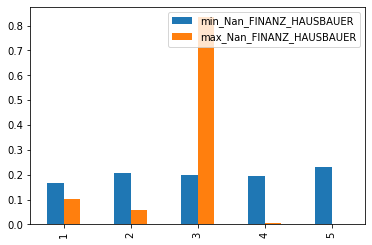

In [108]:
df_dis_bouth = pd.DataFrame(list_dis_bouth[6],index=list_key_bouth[6] ,columns=['min_Nan_'+col_non_Nan[6],'max_Nan_'+col_non_Nan[6]])
df_dis_bouth.plot.bar();
#sorce:
#http://pandas-docs.github.io/pandas-docs-travis/user_guide/visualization.html

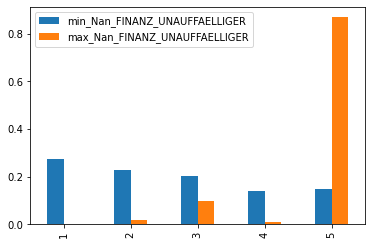

In [109]:
df_dis_bouth = pd.DataFrame(list_dis_bouth[5],index=list_key_bouth[5] ,columns=['min_Nan_'+col_non_Nan[5],'max_Nan_'+col_non_Nan[5]])
df_dis_bouth.plot.bar();

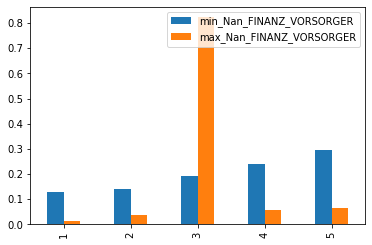

In [110]:
df_dis_bouth = pd.DataFrame(list_dis_bouth[3],index=list_key_bouth[3] ,columns=['min_Nan_'+col_non_Nan[3],'max_Nan_'+col_non_Nan[3]])
df_dis_bouth.plot.bar();

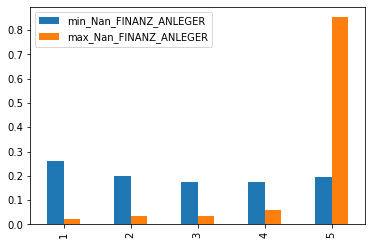

In [111]:
df_dis_bouth = pd.DataFrame(list_dis_bouth[4],index=list_key_bouth[4] ,columns=['min_Nan_'+col_non_Nan[4],'max_Nan_'+col_non_Nan[4]])
df_dis_bouth.plot.bar();

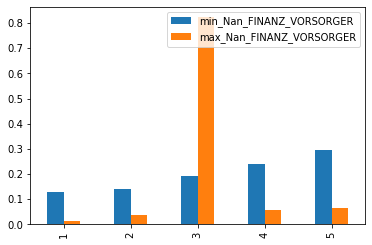

In [112]:
df_dis_bouth = pd.DataFrame(list_dis_bouth[3],index=list_key_bouth[3] ,columns=['min_Nan_'+col_non_Nan[3],'max_Nan_'+col_non_Nan[3]])
df_dis_bouth.plot.bar();

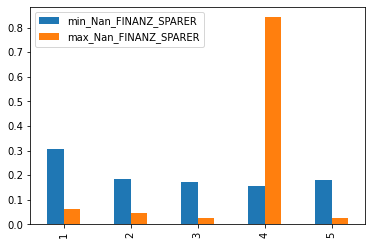

In [113]:
df_dis_bouth = pd.DataFrame(list_dis_bouth[2],index=list_key_bouth[2] ,columns=['min_Nan_'+col_non_Nan[2],'max_Nan_'+col_non_Nan[2]])
df_dis_bouth.plot.bar();

#### Discussion 1.1.3: Assess Missing Data in Each Row

We find that our data is complete in the largest number of rows, and then there is little data missing in the rest of the rows, except for a limited percentage of the rows that have a large number of missing data.

Also, we notice that there is a clear qualitative difference in the data between the group that has the missing values with a low percentage, from the data in the group that has the missing values with a high percentage.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [114]:
# How many features are there of each data type?

In [115]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [116]:
num_feat = len(feat_info.groupby(by='type').size())

print('There are {} kind of features'.format(num_feat))

There are 5 kind of features


In [117]:
# Here how many every one has
feat_info.groupby(by='type').size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

In [118]:
# We may not be committed to the same order of steps here,
# so it should be noted

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [119]:
# Extract the names of the categorical columns, and the mixed columns,
# from feat_info file

In [120]:
mixed , categorical = feat_info[feat_info['type']=='mixed']['attribute'] , feat_info[feat_info['type']=='categorical']['attribute']

# take a look
print(mixed, mixed.size, categorical, categorical.size ,sep='\n'*2)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

7

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

21


In [121]:
# Exclude columns that were previously removed, and remove it from mixed
mixed = list(set(mixed) - set(list_out_lier))
len(mixed)

6

In [122]:
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX',
 'PRAEGENDE_JUGENDJAHRE']

In [123]:
# Exclude columns that were previously removed, and remove it from categorical
categorical = list(set(categorical) - set(list_out_lier))
len(categorical)

18

In [124]:
# Look at the data in the mixed
azdias_min_Nan[mixed]

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX,PRAEGENDE_JUGENDJAHRE
1,21.0,6.0,4.0,51,1.0,14.0
2,3.0,1.0,2.0,24,1.0,15.0
3,NaN,NaN,7.0,12,1.0,8.0
4,32.0,10.0,3.0,43,2.0,8.0
5,8.0,2.0,7.0,54,1.0,3.0
...,...,...,...,...,...,...
891216,2.0,1.0,3.0,41,1.0,14.0
891217,2.0,1.0,5.0,51,4.0,10.0
891218,NaN,NaN,7.0,24,1.0,14.0
891219,29.0,9.0,5.0,51,5.0,14.0


In [125]:
# Look at the data in the categorical
azdias_min_Nan[categorical]

,GREEN_AVANTGARDE,SHOPPER_TYP,VERS_TYP,LP_FAMILIE_FEIN,FINANZTYP,OST_WEST_KZ,ANREDE_KZ,CAMEO_DEU_2015,GFK_URLAUBERTYP,CAMEO_DEUG_2015,LP_STATUS_GROB,NATIONALITAET_KZ,ZABEOTYP,LP_FAMILIE_GROB,SOHO_KZ,LP_STATUS_FEIN,CJT_GESAMTTYP,GEBAEUDETYP
1,0,3.0,2.0,5.0,1,W,2,8A,10.0,8,1.0,1.0,5,3.0,1.0,2.0,5.0,8.0
2,1,2.0,1.0,1.0,1,W,2,4C,10.0,4,2.0,1.0,5,1.0,0.0,3.0,3.0,1.0
3,0,1.0,1.0,NaN,6,W,2,2A,1.0,2,4.0,1.0,3,NaN,0.0,9.0,2.0,1.0
4,0,2.0,2.0,10.0,5,W,1,6B,5.0,6,2.0,1.0,4,5.0,0.0,3.0,5.0,1.0
5,0,0.0,2.0,1.0,2,W,2,8C,1.0,8,2.0,1.0,4,1.0,0.0,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,0,3.0,1.0,1.0,1,W,2,7A,12.0,7,1.0,1.0,4,1.0,0.0,2.0,5.0,8.0
891217,0,NaN,NaN,1.0,6,W,1,9D,1.0,9,1.0,NaN,6,1.0,0.0,1.0,4.0,8.0
891218,0,2.0,1.0,NaN,1,W,2,4C,10.0,4,2.0,1.0,4,NaN,0.0,4.0,4.0,8.0
891219,0,0.0,2.0,9.0,1,W,1,9D,9.0,9,1.0,1.0,5,5.0,0.0,2.0,3.0,8.0


In [126]:
azdias_min_Nan.info(verbose=bool)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798276 entries, 1 to 891220
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   795473 non-null  float64
 1   ANREDE_KZ              798276 non-null  int64  
 2   CJT_GESAMTTYP          793524 non-null  float64
 3   FINANZ_MINIMALIST      798276 non-null  int64  
 4   FINANZ_SPARER          798276 non-null  int64  
 5   FINANZ_VORSORGER       798276 non-null  int64  
 6   FINANZ_ANLEGER         798276 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  798276 non-null  int64  
 8   FINANZ_HAUSBAUER       798276 non-null  int64  
 9   FINANZTYP              798276 non-null  int64  
 10  GFK_URLAUBERTYP        793524 non-null  float64
 11  GREEN_AVANTGARDE       798276 non-null  int64  
 12  HEALTH_TYP             761546 non-null  float64
 13  LP_LEBENSPHASE_FEIN    748033 non-null  float64
 14  LP_LEBENSPHASE_GROB    750926 non-nu

In [127]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_max_Nan = pd.get_dummies(azdias_max_Nan, columns=categorical)
azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=categorical)

In [128]:
azdias_min_Nan.shape

(798276, 199)

In [129]:
# Investigate 'LP_LEBENSPHASE_GROB_ordinal' and engineer two new variables.

In [130]:
azdias_min_Nan['LP_LEBENSPHASE_GROB']

1          6.0
2          1.0
3          NaN
4         10.0
5          2.0
          ... 
891216     1.0
891217     1.0
891218     NaN
891219     9.0
891220     2.0
Name: LP_LEBENSPHASE_GROB, Length: 798276, dtype: float64

 With the help of the "Data_Dictionary" file, 
 
 We'll take a look at "LP_LEBENSPHASE_GROB" from mixed type of data

### 1.12. LP_LEBENSPHASE_GROB

Life stage, rough scale

-  1: single low-income and average earners of younger age

-  2: single low-income and average earners of higher age

-  3: single high-income earners

-  4: single low-income and average-earner couples

-  5: single high-income earner couples

-  6: single parents

-  7: single low-income and average earner families

-  8: high-income earner families

-  9: average earners of younger age from multiperson households

- 10: low-income and average earners of higher age from multiperson households

- 11: high-income earners of younger age from multiperson households

- 12: high-income earners of higher age from multiperson households

as we see, there is 3 level of income earners,

high , Which we will give the value 1

average , Which we will give the value 2

low , Which we will give the value 3

According to the following

In [131]:
dic_LP_LE_GR ={ 1:3, 2:3, 3:1, 4:3, 5:1, 6:np.nan, 7:3, 8:1, 9:2, 10:3, 11:1, 12:1 }

This "LP_LE_GR" is an acronym for "LP_LEBENSPHASE_GROB"

For "categorical" type of data in "LP_LEBENSPHASE_GROB", we will apply one hot encoding to it later

In [132]:
# We create a special column, to reset the data in ascending order
azdias_max_Nan['LP_LEBENSPHASE_GROB_ordinal'] = np.nan
azdias_min_Nan['LP_LEBENSPHASE_GROB_ordinal'] = np.nan

In [133]:
# Set data according to its corresponding
for k,v in dic_LP_LE_GR.items():
    azdias_max_Nan['LP_LEBENSPHASE_GROB_ordinal'][azdias_max_Nan['LP_LEBENSPHASE_GROB'] == k] = v
    azdias_min_Nan['LP_LEBENSPHASE_GROB_ordinal'][azdias_min_Nan['LP_LEBENSPHASE_GROB'] == k] = v

<ipython-input-133-20e543f3c9ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['LP_LEBENSPHASE_GROB_ordinal'][azdias_max_Nan['LP_LEBENSPHASE_GROB'] == k] = v
<ipython-input-133-20e543f3c9ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_min_Nan['LP_LEBENSPHASE_GROB_ordinal'][azdias_min_Nan['LP_LEBENSPHASE_GROB'] == k] = v
<ipython-input-133-20e543f3c9ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdia

In [134]:
azdias_min_Nan.shape

(798276, 200)

Now we'll apply one hot encoding (get_dummies) to 'LP_LEBENSPHASE_GROB' for rest of data in thise (mixed) data.

Next, we'll do the same on the rest of the mixed type of data.

In [135]:
azdias_max_Nan = pd.get_dummies(azdias_max_Nan, columns=['LP_LEBENSPHASE_GROB'])
azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=['LP_LEBENSPHASE_GROB'])

In [136]:
azdias_min_Nan.shape

(798276, 211)

In [137]:
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX',
 'PRAEGENDE_JUGENDJAHRE']

We repeat the procedure for anther 'mixed' data

With the help of the "Data_Dictionary" file, 
 
 We'll take a look at "WOHNLAGE" from mixed type of data

### 3.7. WOHNLAGE

Neighborhood quality (or rural flag)

- -1: unknown

-  0: no score calculated

-  1: very good neighborhood

-  2: good neighborhood

-  3: average neighborhood

-  4: poor neighborhood

-  5: very poor neighborhood

-  7: rural neighborhood

-  8: new building in rural neighborhood

At first, there is a note. We see that the value "0" indicates a missing value, "0: no score calculated" but the note here, that in the "feat_info" file it is not denoted as a missing value, so we will here, with personal effort, convert it to a missing value

Here we see an ascending order of neighborhoods within cities on the one hand. On the other hand, we also see a different arrangement of rural areas.

Therefore, we will divide it into several stages and levels as follows

This "WOH" is an acronym for "WOHNLAGE"

In [138]:
list_WOH_ordinal_1 = list(range(1,6))

In [139]:
dic_WOH_ordinal_2 = {7:1, 8:2}

In [140]:
dic_WOH_categorical = {1:10, 2:10, 3:10, 4:10, 5:10, 7:20, 8:20}

In [141]:
azdias_max_Nan['WOHNLAGE_ordinal_1'] = np.nan
azdias_min_Nan['WOHNLAGE_ordinal_1'] = np.nan

In [142]:
azdias_max_Nan['WOHNLAGE_ordinal_2'] = np.nan
azdias_min_Nan['WOHNLAGE_ordinal_2'] = np.nan

In [143]:
list(azdias_min_Nan[['WOHNLAGE']].groupby(by='WOHNLAGE').indices.keys())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0]

In [144]:
# According to "Data_Dictionary" file "0" denotes unobserved information,
# that is for, we will convert it to Nan's
azdias_min_Nan.loc[:,'WOHNLAGE'].replace(to_replace=0, value=np.nan,inplace=True)

In [145]:
list(azdias_min_Nan[['WOHNLAGE']].groupby(by='WOHNLAGE').indices.keys())

[1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0]

In [146]:
# Set data according to its corresponding
for a in list_WOH_ordinal_1:
    azdias_max_Nan['WOHNLAGE_ordinal_1'][azdias_max_Nan['WOHNLAGE'] == a] = a
    azdias_min_Nan['WOHNLAGE_ordinal_1'][azdias_min_Nan['WOHNLAGE'] == a] = a

<ipython-input-146-3d6af4eb1b5d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['WOHNLAGE_ordinal_1'][azdias_max_Nan['WOHNLAGE'] == a] = a
<ipython-input-146-3d6af4eb1b5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_min_Nan['WOHNLAGE_ordinal_1'][azdias_min_Nan['WOHNLAGE'] == a] = a
<ipython-input-146-3d6af4eb1b5d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['WOHNLAGE_ordinal_1'][azdias_m

In [147]:
# Set data according to its corresponding
for k,v in dic_WOH_ordinal_2.items():
    azdias_max_Nan['WOHNLAGE_ordinal_2'][azdias_max_Nan['WOHNLAGE'] == k] = v
    azdias_min_Nan['WOHNLAGE_ordinal_2'][azdias_min_Nan['WOHNLAGE'] == k] = v

<ipython-input-147-9e5706fa905f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['WOHNLAGE_ordinal_2'][azdias_max_Nan['WOHNLAGE'] == k] = v
<ipython-input-147-9e5706fa905f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_min_Nan['WOHNLAGE_ordinal_2'][azdias_min_Nan['WOHNLAGE'] == k] = v
<ipython-input-147-9e5706fa905f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['WOHNLAGE_ordinal_2'][azdias_m

In [148]:
# Set data according to its corresponding
for k,v in dic_WOH_categorical.items():
    azdias_max_Nan['WOHNLAGE'][azdias_max_Nan['WOHNLAGE'] == k] = v
    azdias_min_Nan['WOHNLAGE'][azdias_min_Nan['WOHNLAGE'] == k] = v

<ipython-input-148-415fe16d7380>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['WOHNLAGE'][azdias_max_Nan['WOHNLAGE'] == k] = v
<ipython-input-148-415fe16d7380>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_min_Nan['WOHNLAGE'][azdias_min_Nan['WOHNLAGE'] == k] = v
<ipython-input-148-415fe16d7380>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['WOHNLAGE'][azdias_max_Nan['WOHNLAGE'] == k] = v
<

In [149]:
# Now we'll apply one hot encoding (get_dummies) to 'WOHNLAGE'
# for rest of data in thise (mixed) data.
azdias_max_Nan = pd.get_dummies(azdias_max_Nan, columns=['WOHNLAGE'])
azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=['WOHNLAGE'])

In [150]:
azdias_min_Nan.shape

(798276, 214)

In [151]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

We repeat the procedure for anther 'mixed' data

With the help of the "Data_Dictionary" file, 
 
 We'll take a look at "PRAEGENDE_JUGENDJAHRE" from mixed type of data

### 1.18. PRAEGENDE_JUGENDJAHRE

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

- -1: unknown

-  0: unknown

-  1: 40s - war years (Mainstream, E+W)

-  2: 40s - reconstruction years (Avantgarde, E+W)

-  3: 50s - economic miracle (Mainstream, E+W)

-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)

-  5: 60s - economic miracle (Mainstream, E+W)

-  6: 60s - generation 68 / student protestors (Avantgarde, W)

-  7: 60s - opponents to the building of the Wall (Avantgarde, E)

-  8: 70s - family orientation (Mainstream, E+W)

-  9: 70s - peace movement (Avantgarde, E+W)

- 10: 80s - Generation Golf (Mainstream, W)

- 11: 80s - ecological awareness (Avantgarde, W)

- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)

- 13: 80s - Swords into ploughshares (Avantgarde, E)

- 14: 90s - digital media kids (Mainstream, E+W)

- 15: 90s - ecological awareness (Avantgarde, E+W)

Therefore, we will deal with it as follows


In [152]:
dic_PR_JU ={ 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6 }

We repeat the procedure

In [153]:
azdias_max_Nan['PRAEGENDE_JUGENDJAHRE_ordinal'] = np.nan
azdias_min_Nan['PRAEGENDE_JUGENDJAHRE_ordinal'] = np.nan

In [154]:
# Set data according to its corresponding
for k,v in dic_PR_JU.items():
    azdias_max_Nan['PRAEGENDE_JUGENDJAHRE_ordinal'][azdias_max_Nan['PRAEGENDE_JUGENDJAHRE'] == k] = v
    azdias_min_Nan['PRAEGENDE_JUGENDJAHRE_ordinal'][azdias_min_Nan['PRAEGENDE_JUGENDJAHRE'] == k] = v

<ipython-input-154-92c7df1a1408>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['PRAEGENDE_JUGENDJAHRE_ordinal'][azdias_max_Nan['PRAEGENDE_JUGENDJAHRE'] == k] = v
<ipython-input-154-92c7df1a1408>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_min_Nan['PRAEGENDE_JUGENDJAHRE_ordinal'][azdias_min_Nan['PRAEGENDE_JUGENDJAHRE'] == k] = v
<ipython-input-154-92c7df1a1408>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [155]:
azdias_min_Nan['PRAEGENDE_JUGENDJAHRE'].count()

769514

In [156]:
azdias_min_Nan['PRAEGENDE_JUGENDJAHRE_ordinal'].count()

769514

In [157]:
# Now we'll apply one hot encoding (get_dummies) to 'WOHNLAGE'
# for rest of data in thise (mixed) data.
azdias_max_Nan = pd.get_dummies(azdias_max_Nan, columns=['PRAEGENDE_JUGENDJAHRE'])
azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=['PRAEGENDE_JUGENDJAHRE'])

In [158]:
azdias_min_Nan.shape

(798276, 229)

In [159]:
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX',
 'PRAEGENDE_JUGENDJAHRE']

In [160]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

We repeat the procedure for anther 'mixed' data

With the help of the "Data_Dictionary" file, 
 
 We'll take a look at "CAMEO_INTL_2015" from mixed type of data
 

### 4.3. CAMEO_INTL_2015

German CAMEO: Wealth / Life Stage Typology, mapped to international code

- -1: unknown

- 11: Wealthy Households - Pre-Family Couples & Singles

- 12: Wealthy Households - Young Couples With Children

- 13: Wealthy Households - Families With School Age Children

- 14: Wealthy Households - Older Families &  Mature Couples

- 15: Wealthy Households - Elders In Retirement

- 21: Prosperous Households - Pre-Family Couples & Singles

- 22: Prosperous Households - Young Couples With Children

- 23: Prosperous Households - Families With School Age Children

- 24: Prosperous Households - Older Families & Mature Couples

- 25: Prosperous Households - Elders In Retirement

- 31: Comfortable Households - Pre-Family Couples & Singles

- 32: Comfortable Households - Young Couples With Children

- 33: Comfortable Households - Families With School Age Children

- 34: Comfortable Households - Older Families & Mature Couples

- 35: Comfortable Households - Elders In Retirement

- 41: Less Affluent Households - Pre-Family Couples & Singles

- 42: Less Affluent Households - Young Couples With Children

- 43: Less Affluent Households - Families With School Age Children

- 44: Less Affluent Households - Older Families & Mature Couples

- 45: Less Affluent Households - Elders In Retirement

- 51: Poorer Households - Pre-Family Couples & Singles

- 52: Poorer Households - Young Couples With Children

- 53: Poorer Households - Families With School Age Children

- 54: Poorer Households - Older Families & Mature Couples

- 55: Poorer Households - Elders In Retirement

- XX: unknown


Therefore, we will deal with it as follows

In [161]:
list_CA_IN_2015_ordinal = list()

for i,a in enumerate(range(10,60,10)):
    for b in range(a,a+6):
        list_CA_IN_2015_ordinal.append([b, i+1])
        
list_CA_IN_2015_ordinal

[[10, 1],
 [11, 1],
 [12, 1],
 [13, 1],
 [14, 1],
 [15, 1],
 [20, 2],
 [21, 2],
 [22, 2],
 [23, 2],
 [24, 2],
 [25, 2],
 [30, 3],
 [31, 3],
 [32, 3],
 [33, 3],
 [34, 3],
 [35, 3],
 [40, 4],
 [41, 4],
 [42, 4],
 [43, 4],
 [44, 4],
 [45, 4],
 [50, 5],
 [51, 5],
 [52, 5],
 [53, 5],
 [54, 5],
 [55, 5]]

In [162]:
list_CA_IN_2015_categorical = list()

for a in range(1,6):
    for b in range(10,60,10):
        list_CA_IN_2015_categorical.append([b+a,a])
        
list_CA_IN_2015_categorical

[[11, 1],
 [21, 1],
 [31, 1],
 [41, 1],
 [51, 1],
 [12, 2],
 [22, 2],
 [32, 2],
 [42, 2],
 [52, 2],
 [13, 3],
 [23, 3],
 [33, 3],
 [43, 3],
 [53, 3],
 [14, 4],
 [24, 4],
 [34, 4],
 [44, 4],
 [54, 4],
 [15, 5],
 [25, 5],
 [35, 5],
 [45, 5],
 [55, 5]]

In [163]:
azdias_max_Nan['CAMEO_INTL_2015_ordinal'] = np.nan
azdias_min_Nan['CAMEO_INTL_2015_ordinal'] = np.nan

In [164]:
type(azdias_min_Nan['CAMEO_INTL_2015'][1])

str

In [165]:
azdias_min_Nan['CAMEO_INTL_2015'][1]

'51'

In [166]:
object_type = list()
for a in azdias:
    if azdias[a].dtype == object:
        object_type.append(a)
object_type


['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

In [167]:
for a in list_CA_IN_2015_ordinal:
    azdias_min_Nan['CAMEO_INTL_2015_ordinal'][ azdias_min_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]
    azdias_max_Nan['CAMEO_INTL_2015_ordinal'][ azdias_max_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]

<ipython-input-167-8bcdcde14ff4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_min_Nan['CAMEO_INTL_2015_ordinal'][ azdias_min_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]
<ipython-input-167-8bcdcde14ff4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['CAMEO_INTL_2015_ordinal'][ azdias_max_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]


In [168]:
for a in list_CA_IN_2015_categorical:
    azdias_min_Nan['CAMEO_INTL_2015'][ azdias_min_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]
    azdias_max_Nan['CAMEO_INTL_2015'][ azdias_max_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]

<ipython-input-168-0aa67cf34ce0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_min_Nan['CAMEO_INTL_2015'][ azdias_min_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]
<ipython-input-168-0aa67cf34ce0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_max_Nan['CAMEO_INTL_2015'][ azdias_max_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]


In [169]:
azdias_max_Nan = pd.get_dummies(azdias_max_Nan, columns=['CAMEO_INTL_2015'])
azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=['CAMEO_INTL_2015'])

To run out of time, in principle, we will apply get_dummies on the rest mixed type of data

In [170]:
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX',
 'PRAEGENDE_JUGENDJAHRE']

In [171]:
# tow lift to do
col_to_encod = ['LP_LEBENSPHASE_FEIN','PLZ8_BAUMAX']

In [172]:
for a in col_to_encod:
    azdias_max_Nan = pd.get_dummies(azdias_max_Nan, columns=[a])
    azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=[a])

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [173]:
# Because I started with the initial processing of the data before paying attention to the details of the steps
# in the project, it happened that some steps were preempted.
# So I'm going to implement some directions here on new  upload of data, just to perform the task separately,
# since we did it on our own data.

data = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [174]:
data[object_type]

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
0,NaN,NaN,NaN,NaN
1,W,8,8A,51
2,W,4,4C,24
3,W,2,2A,12
4,W,6,6B,43
...,...,...,...,...
891216,W,7,7A,41
891217,W,9,9D,51
891218,W,4,4C,24
891219,W,9,9D,51


In [175]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_type = {'binary': list(), 'multi_level': list() }

for a in categorical:
    data_level = len(data[[a]].dropna().groupby(by=a).indices)
    if data_level == 2:
        categorical_type['binary'].append(a)
    else:
        categorical_type['multi_level'].append(a)

In [176]:
print('The binary is: {} {} {} The multi_level is: {} {}' \
      .format('\n',categorical_type['binary'],'\n'*2,'\n',categorical_type['multi_level']))

The binary is: 
 ['GREEN_AVANTGARDE', 'OST_WEST_KZ', 'ANREDE_KZ', 'SOHO_KZ'] 

 The multi_level is: 
 ['SHOPPER_TYP', 'VERS_TYP', 'LP_FAMILIE_FEIN', 'FINANZTYP', 'CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'CAMEO_DEUG_2015', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'ZABEOTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'CJT_GESAMTTYP', 'GEBAEUDETYP']


In [177]:
data_valu = dict()
for a in categorical_type['binary']:
    data_valu[a] = data[[a]].dropna().groupby(by=a).indices
for a in data_valu.values():
    print(a.keys())

dict_keys([0, 1])
dict_keys(['O', 'W'])
dict_keys([1, 2])
dict_keys([0.0, 1.0])


In [178]:
dic_dtype = {}
for k,v in data.dtypes.items():
    if str(v) not in dic_dtype:
        dic_dtype[str(v)] = [str(k)]
    else:
        dic_dtype[str(v)].append(k)

dic_dtype.keys()

dict_keys(['int64', 'float64', 'object'])

In [179]:
dic_dtype_min = {}
for k,v in azdias_min_Nan.dtypes.items():
    if str(v) not in dic_dtype_min:
        dic_dtype_min[str(v)] = [str(k)]
    else:
        dic_dtype_min[str(v)].append(str(k))

dic_dtype_min.keys()

dict_keys(['float64', 'int64', 'uint8'])

In [180]:
dic_dtype['object']

['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

In [181]:
data[dic_dtype['object']]

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
0,NaN,NaN,NaN,NaN
1,W,8,8A,51
2,W,4,4C,24
3,W,2,2A,12
4,W,6,6B,43
...,...,...,...,...
891216,W,7,7A,41
891217,W,9,9D,51
891218,W,4,4C,24
891219,W,9,9D,51


In [182]:
dic_uniqe_valus = dict()
for a in dic_dtype['object']:
    dic_uniqe_valus[a] = list(data[[a]].groupby(by=a).indices.keys())
    print('< {} > has {} number of unique values'.format(a, len(dic_uniqe_valus[a])),'\n')
    
print(dic_uniqe_valus)

< OST_WEST_KZ > has 2 number of unique values 

< CAMEO_DEUG_2015 > has 10 number of unique values 

< CAMEO_DEU_2015 > has 45 number of unique values 

< CAMEO_INTL_2015 > has 22 number of unique values 

{'OST_WEST_KZ': ['O', 'W'], 'CAMEO_DEUG_2015': ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'X'], 'CAMEO_DEU_2015': ['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E', 'XX'], 'CAMEO_INTL_2015': ['12', '13', '14', '15', '22', '23', '24', '25', '31', '32', '33', '34', '35', '41', '43', '44', '45', '51', '52', '54', '55', 'XX']}


In [183]:
# Because I have implemented "get_dummies" on all the "categorical" type of data
# I will not have to check 

In [184]:
for k,v in categorical_type.items():
    for a in v:
        if a in out_lier : print('in out_lier')
        if a in mixed: print('in mixed')

In [185]:
# Re-encode categorical variable(s) to be kept in the analysis.
data[categorical_type['binary']]

,GREEN_AVANTGARDE,OST_WEST_KZ,ANREDE_KZ,SOHO_KZ
0,0,NaN,1,NaN
1,0,W,2,1.0
2,1,W,2,0.0
3,0,W,2,0.0
4,0,W,1,0.0
...,...,...,...,...
891216,0,W,2,0.0
891217,0,W,1,0.0
891218,0,W,2,0.0
891219,0,W,1,0.0


In [186]:
# as we see for exampel
azdias_min_Nan['OST_WEST_KZ_W']

1         1
2         1
3         1
4         1
5         1
         ..
891216    1
891217    1
891218    1
891219    1
891220    1
Name: OST_WEST_KZ_W, Length: 798276, dtype: uint8

In [187]:
# we already did it , in anther way

In [188]:
#  for a in data.groupby(by=data.dtypes):
#      print(a)
#  { str(k) : list(v) for k,v in data.groupby(data.dtypes, axis=1)}
#  
#  # sorce: https://stackoverflow.com/questions/53678519/grouping-columns-by-data-type-in-pandas-series-throws-typeerror-data-type-not-u

#### Discussion 1.2.1: Re-Encode Categorical Features

We did not delete anything, we applied one hot encoding to all Categorical Features, and thus we accomplished the task in a short way.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [189]:
# We did it with the previous step

#### Discussion 1.2.2: Engineer Mixed-Type Features

We found a lot of overlapping data, which deserves to be analyzed, separated and dealt with specifically for each feature, and this is what we did as much as possible, and on the other hand we did not delete anything, we kept as much as possible. And we encoded what needs to be in ascending and hierarchical order by properties.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [190]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [191]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



In [192]:
# I already did it

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [193]:
def clean_data(df_data):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Identify missing or unknown data values and convert them to NaNs.
    azdias = df_data
    for i,a in enumerate(zip(azdias.columns,feat_info['missing_or_unknown'])):
        s = azdias[a[0]]
        X = 'X'
        XX = 'XX'
        Nan = eval(a[1])
        if len(Nan) == 0: continue
        azdias[a[0]].replace(Nan, np.nan ,inplace=True)
    
    # remove selected columns and rows, ...
    out_lier = list()
    for a in df_data:
        if df_data[a].isna().sum() > 160000:
            out_lier.append(a)
            
    out_lier = list_out_lier
    
    set_col_azdias = set(azdias.columns)
    set_out_lier = set(list_out_lier) 
    #if len(set_col_azdias.intersection(set_out_lier)) > 0:
    azdias.drop(list_out_lier, axis=1, inplace=True)
    
    rows = azdias.shape[0]
    col = azdias.shape[1]
    
    Thresh = int(col*0.6)
    azdias_min_Nan = azdias.dropna(thresh=Thresh)

    # select, re-encode, and engineer column values.
    
    mixed = ['CAMEO_INTL_2015','PLZ8_BAUMAX','WOHNLAGE','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE'] 
    
    categorical = ['VERS_TYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'ZABEOTYP', 'ANREDE_KZ', 'LP_FAMILIE_GROB', 'GREEN_AVANTGARDE', 'FINANZTYP', 'OST_WEST_KZ', 'LP_FAMILIE_FEIN', 'LP_STATUS_GROB', 'CJT_GESAMTTYP', 'NATIONALITAET_KZ', 'LP_STATUS_FEIN', 'SOHO_KZ', 'CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'SHOPPER_TYP']
    
    azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=categorical)

    
    dic_LP_LE_GR ={ 1:3, 2:3, 3:1, 4:3, 5:1, 6:np.nan, 7:3, 8:1, 9:2, 10:3, 11:1, 12:1 }
    
    azdias_min_Nan['LP_LEBENSPHASE_GROB_ordinal'] = np.nan
    
    
    for k,v in dic_LP_LE_GR.items():
        azdias_min_Nan['LP_LEBENSPHASE_GROB_ordinal'][azdias_min_Nan['LP_LEBENSPHASE_GROB'] == k] = v
        
    azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=['LP_LEBENSPHASE_GROB'])

    azdias_min_Nan['WOHNLAGE_ordinal_1'] = np.nan
    azdias_min_Nan['WOHNLAGE_ordinal_2'] = np.nan

    list_WOH_ordinal_1 = list(range(1,6))
    dic_WOH_ordinal_2 = {7:1, 8:2}
    dic_WOH_categorical = {1:10, 2:10, 3:10, 4:10, 5:10, 7:20, 8:20}
    
    azdias_min_Nan.loc[:,'WOHNLAGE'].replace(to_replace=0, value=np.nan,inplace=True)
    
    for a in list_WOH_ordinal_1:
        azdias_min_Nan['WOHNLAGE_ordinal_1'][azdias_min_Nan['WOHNLAGE'] == a] = a
    
    for k,v in dic_WOH_ordinal_2.items():
        azdias_min_Nan['WOHNLAGE_ordinal_2'][azdias_min_Nan['WOHNLAGE'] == k] = v
    
    for k,v in dic_WOH_categorical.items():
        azdias_min_Nan['WOHNLAGE'][azdias_min_Nan['WOHNLAGE'] == k] = v
    
    azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=['WOHNLAGE'])
    
    azdias_min_Nan['PRAEGENDE_JUGENDJAHRE_ordinal'] = np.nan
    
    dic_PR_JU ={ 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6 }
    
    for k,v in dic_PR_JU.items():
        azdias_min_Nan['PRAEGENDE_JUGENDJAHRE_ordinal'][azdias_min_Nan['PRAEGENDE_JUGENDJAHRE'] == k] = v

    azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=['PRAEGENDE_JUGENDJAHRE'])
    
    azdias_min_Nan['CAMEO_INTL_2015_ordinal'] = np.nan
    
    list_CA_IN_2015_ordinal = list()
    for i,a in enumerate(range(10,60,10)):
        for b in range(a,a+6):
            list_CA_IN_2015_ordinal.append([b, i+1])
            
    for a in list_CA_IN_2015_ordinal:
        azdias_min_Nan['CAMEO_INTL_2015_ordinal'][ azdias_min_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]
    
    list_CA_IN_2015_categorical = list()
    for a in range(1,6):
        for b in range(10,60,10):
            list_CA_IN_2015_categorical.append([b+a,a])

    for a in list_CA_IN_2015_categorical:
        azdias_min_Nan['CAMEO_INTL_2015'][ azdias_min_Nan['CAMEO_INTL_2015'] == str(a[0])] = a[1]

    azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=['CAMEO_INTL_2015'])
    
    azdias_min_Nan['GEBAEUDETYP_5.0'] = 0
    
    col_to_encod = ['LP_LEBENSPHASE_FEIN','PLZ8_BAUMAX']
    
    for a in col_to_encod:
        azdias_min_Nan = pd.get_dummies(azdias_min_Nan, columns=[a])
        
    # Return the cleaned dataframe.
    
    return azdias_min_Nan
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [194]:
azdias_min_Nan.info(verbose=bool, null_counts=bool)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798276 entries, 1 to 891220
Data columns (total 277 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ALTERSKATEGORIE_GROB           795473 non-null  float64
 1   FINANZ_MINIMALIST              798276 non-null  int64  
 2   FINANZ_SPARER                  798276 non-null  int64  
 3   FINANZ_VORSORGER               798276 non-null  int64  
 4   FINANZ_ANLEGER                 798276 non-null  int64  
 5   FINANZ_UNAUFFAELLIGER          798276 non-null  int64  
 6   FINANZ_HAUSBAUER               798276 non-null  int64  
 7   HEALTH_TYP                     761546 non-null  float64
 8   RETOURTYP_BK_S                 793524 non-null  float64
 9   SEMIO_SOZ                      798276 non-null  int64  
 10  SEMIO_FAM                      798276 non-null  int64  
 11  SEMIO_REL                      798276 non-null  int64  
 12  SEMIO_MAT                    

In [195]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imp_mean = SimpleImputer()
imp_mean.fit(azdias_min_Nan)
data_imp = imp_mean.transform(azdias_min_Nan)

In [196]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler(with_mean=0, with_std=1)
data_scal = scaler.fit_transform(data_imp)

### Discussion 2.1: Apply Feature Scaling

We chose to apply SimpleImputer and StandardScaler as flexible, standard and at the same time fast options, because our limited time was something we had to take into account.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [197]:
# Apply PCA to the data.
pca = PCA(n_components=50)
pca_data_fit = pca.fit(data_scal)
pca_data_tran = pca.transform(data_scal)

In [198]:
pca.components_

array([[-0.06782944, -0.17132793,  0.09610558, ...,  0.05642173,
         0.07293244,  0.10026106],
       [ 0.21083172,  0.09224154, -0.21484428, ...,  0.02057462,
         0.02223711,  0.02632474],
       [-0.00137283,  0.11246132, -0.03205314, ...,  0.01025933,
         0.01641516,  0.04884058],
       ...,
       [ 0.04541291,  0.01145533, -0.00940586, ..., -0.02381575,
        -0.06354696, -0.06368591],
       [ 0.00213576,  0.00340285,  0.00677569, ..., -0.04942366,
         0.03317095, -0.02591261],
       [-0.04633142,  0.0162451 , -0.04111887, ..., -0.00039541,
        -0.01420073,  0.03513993]])

In [199]:
pca.components_.shape

(50, 277)

In [200]:
pca == pca_data_fit

True

In [201]:
pca_data_tran

array([[ 4.79295969, -4.66986582, -3.63662314, ...,  0.9816081 ,
         1.96444936, -0.81926127],
       [-0.27498992, -1.67004699, -2.99741805, ...,  1.10021384,
        -1.7316335 , -2.51884683],
       [-5.05305767,  1.47477448, -2.43944752, ...,  0.11376341,
        -0.34219443, -0.32499715],
       ...,
       [-1.2505862 , -4.2175697 , -4.04712813, ...,  0.88252033,
        -0.47721439, -0.46975218],
       [ 6.73216057, -5.05210499,  3.35785521, ...,  2.01011377,
        -0.51250767, -0.7411985 ],
       [ 0.96111864,  3.53259296,  1.31629281, ...,  1.54785848,
        -2.3465    , -1.25771119]])

In [202]:
azdias_min_Nan.values

array([[1., 1., 5., ..., 0., 0., 0.],
       [3., 1., 4., ..., 0., 0., 0.],
       [4., 4., 2., ..., 0., 0., 0.],
       ...,
       [2., 2., 4., ..., 0., 0., 0.],
       [1., 1., 5., ..., 0., 0., 1.],
       [4., 4., 2., ..., 0., 0., 0.]])

In [203]:
data_scal

array([[0.98352634, 0.72591183, 3.36650396, ..., 0.        , 0.        ,
        0.        ],
       [2.95057903, 0.72591183, 2.69320317, ..., 0.        , 0.        ,
        0.        ],
       [3.93410538, 2.90364734, 1.34660158, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.96705269, 1.45182367, 2.69320317, ..., 0.        , 0.        ,
        0.        ],
       [0.98352634, 0.72591183, 3.36650396, ..., 0.        , 0.        ,
        3.05619926],
       [3.93410538, 2.90364734, 1.34660158, ..., 0.        , 0.        ,
        0.        ]])

In [204]:
azdias_min_Nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798276 entries, 1 to 891220
Columns: 277 entries, ALTERSKATEGORIE_GROB to PLZ8_BAUMAX_5.0
dtypes: float64(40), int64(20), uint8(217)
memory usage: 556.7 MB


In [205]:
pca_data_tran.shape

(798276, 50)

In [206]:
130*794792

103322960

In [207]:
# it is not enogh, but we have to take our limited time into account
pca.explained_variance_ratio_.sum()

0.5541656998730083

In [208]:
pca.explained_variance_ratio_[0:127].sum()

0.5541656998730083

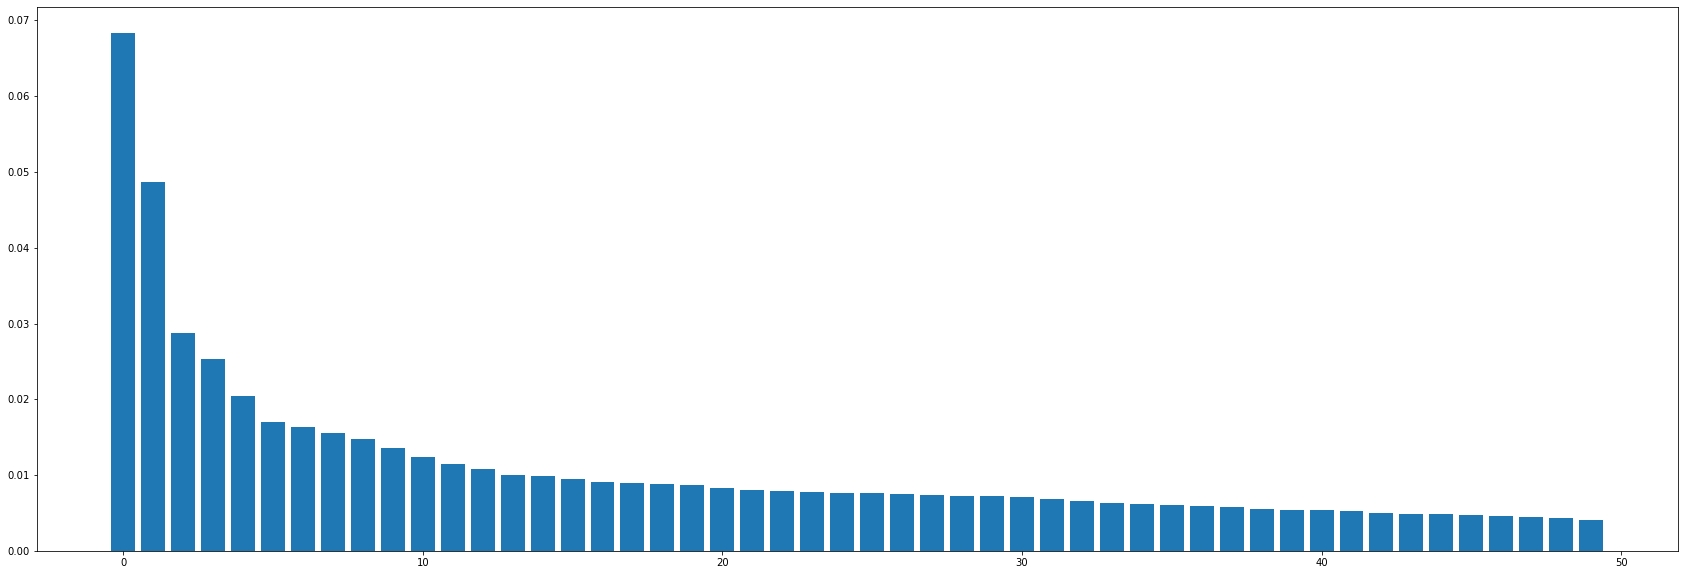

In [209]:
num_comp = list(range(50))
values = pca.explained_variance_ratio_[0:50]

plt.figure(figsize=(100, 10))

plt.subplot(131)
plt.bar(num_comp, values)
plt.show()

In [210]:
pca.explained_variance_ratio_

array([0.06833522, 0.04874408, 0.02872493, 0.02527693, 0.02044942,
       0.01699972, 0.0163453 , 0.01549784, 0.0147155 , 0.01353935,
       0.01243355, 0.01143673, 0.01081002, 0.01006138, 0.00988177,
       0.00946738, 0.00913369, 0.00900723, 0.00877556, 0.00869743,
       0.00831412, 0.00803674, 0.00788256, 0.00779602, 0.00768275,
       0.00759822, 0.00753453, 0.00737513, 0.00721433, 0.00716989,
       0.00712028, 0.00689221, 0.00653628, 0.00630447, 0.00617639,
       0.00607704, 0.00594713, 0.00578177, 0.00557468, 0.00536957,
       0.00532221, 0.00529495, 0.00495347, 0.00492332, 0.00484615,
       0.00469661, 0.00454371, 0.00444359, 0.00430353, 0.00412103])

In [211]:
pca.explained_variance_ratio_.sum()

0.5541656998730083

In [212]:
pca.explained_variance_ratio_[:30].sum()

0.44493732216631615

In [213]:
pca.singular_values_.shape

(50,)

In [214]:
pca.singular_values_

array([3887.21626902, 3283.04893753, 2520.26324569, 2364.16951532,
       2126.45854735, 1938.81913037, 1901.13480331, 1851.19425027,
       1803.86486082, 1730.27599236, 1658.112382  , 1590.25707653,
       1546.07205848, 1491.57511223, 1478.20200843, 1446.87630988,
       1421.14918351, 1411.27613114, 1393.00843957, 1386.79375767,
       1355.8899858 , 1333.08010917, 1320.23169592, 1312.9643993 ,
       1303.39119842, 1296.20109897, 1290.75670541, 1277.03045459,
       1263.03246848, 1259.13604002, 1254.77209215, 1234.51266171,
       1202.21428188, 1180.70265908, 1168.64852257, 1159.21130318,
       1146.75334468, 1130.69834965, 1110.2643597 , 1089.64799527,
       1084.83176987, 1082.0495507 , 1046.57681316, 1043.38717532,
       1035.17791579, 1019.08072004, 1002.35485632,  991.2505905 ,
        975.50313283,  954.59579261])

In [215]:
# Investigate the variance accounted for by each principal component.

In [216]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
pca_data_fit = pca.fit(data_scal)
pca_data_tran = pca.transform(data_scal)

### Discussion 2.2: Perform Dimensionality Reduction

Based on the data that we saw, whether we keep it or remove it, we found that in order to reach high performance, the number of components must be 130 or more, but for the time component we only chose 30.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [217]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
# other cells

sorted_weights_1 = pd.Series(pca.components_[0], index=azdias_min_Nan.columns)
# weights for the first principal component to corresponding feature names
sorted_weights_1

ALTERSKATEGORIE_GROB   -0.067829
FINANZ_MINIMALIST      -0.171328
FINANZ_SPARER           0.096105
FINANZ_VORSORGER       -0.068870
FINANZ_ANLEGER          0.044262
                          ...   
PLZ8_BAUMAX_1.0        -0.153630
PLZ8_BAUMAX_2.0         0.036177
PLZ8_BAUMAX_3.0         0.056422
PLZ8_BAUMAX_4.0         0.072932
PLZ8_BAUMAX_5.0         0.100261
Length: 277, dtype: float64

In [218]:
# now sorted by weight for first principal component
sorted_weights_1 = sorted_weights_1.sort_values(ascending=False)
sorted_weights_1

LP_STATUS_GROB_1.0             0.178905
LP_LEBENSPHASE_GROB_ordinal    0.168930
HH_EINKOMMEN_SCORE             0.168245
CAMEO_INTL_2015_ordinal        0.165432
PLZ8_ANTG3                     0.164721
                                 ...   
KBA05_GBZ                     -0.162835
PLZ8_ANTG1                    -0.164952
FINANZ_MINIMALIST             -0.171328
KBA05_ANTG1                   -0.171962
MOBI_REGIO                    -0.183199
Length: 277, dtype: float64

<AxesSubplot:>

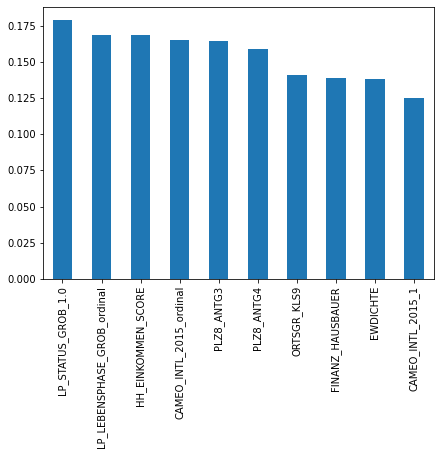

In [219]:
sorted_weights_1[:10].plot.bar(figsize=(7,5))

<AxesSubplot:>

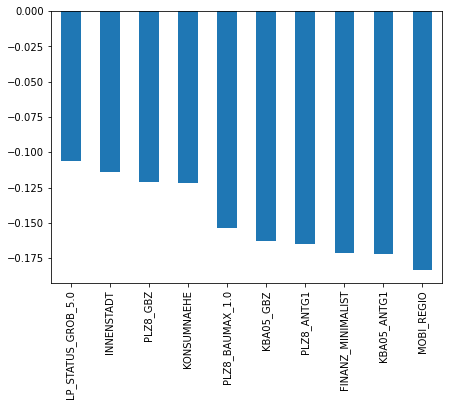

In [220]:
sorted_weights_1[-10:].plot.bar(figsize=(7,5))

In [221]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# weights for the second principal component to corresponding feature names
sorted_weights_2 = pd.Series(pca.components_[1], index=azdias_min_Nan.columns)
sorted_weights_2

ALTERSKATEGORIE_GROB    0.210831
FINANZ_MINIMALIST       0.092242
FINANZ_SPARER          -0.214845
FINANZ_VORSORGER        0.207408
FINANZ_ANLEGER         -0.190975
                          ...   
PLZ8_BAUMAX_1.0        -0.045273
PLZ8_BAUMAX_2.0         0.015921
PLZ8_BAUMAX_3.0         0.020575
PLZ8_BAUMAX_4.0         0.022235
PLZ8_BAUMAX_5.0         0.026326
Length: 277, dtype: float64

<AxesSubplot:>

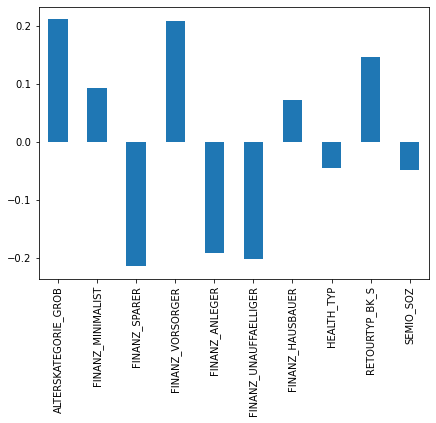

In [222]:
sorted_weights_2[:10].plot.bar(figsize=(7,5))

In [223]:
# now sorted by weight for second principal component
sorted_weights_2 = sorted_weights_2.sort_values(ascending=False)

<AxesSubplot:>

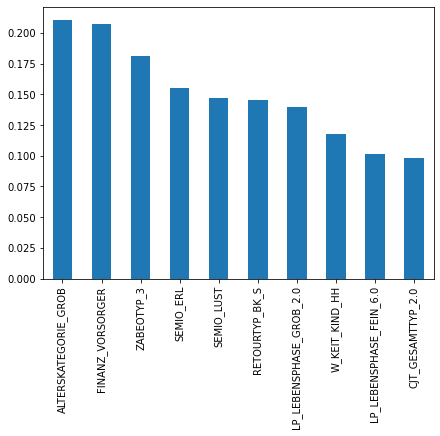

In [224]:
sorted_weights_2[:10].plot.bar(figsize=(7,5))

<AxesSubplot:>

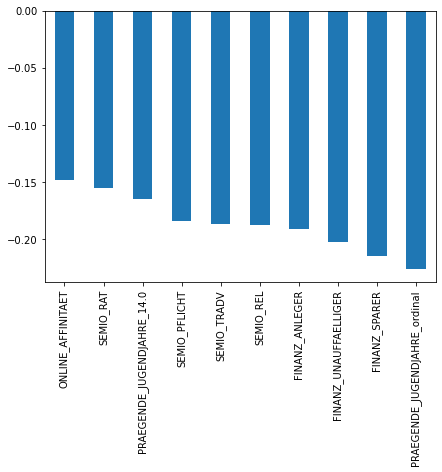

In [225]:
sorted_weights_2[-10:].plot.bar(figsize=(7,5))

In [226]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sorted_weights_3 = pd.Series(pca.components_[2], index=azdias_min_Nan.columns)
sorted_weights_3

ALTERSKATEGORIE_GROB   -0.001390
FINANZ_MINIMALIST       0.112472
FINANZ_SPARER          -0.032072
FINANZ_VORSORGER        0.023225
FINANZ_ANLEGER         -0.132956
                          ...   
PLZ8_BAUMAX_1.0        -0.054492
PLZ8_BAUMAX_2.0         0.014077
PLZ8_BAUMAX_3.0         0.010277
PLZ8_BAUMAX_4.0         0.016475
PLZ8_BAUMAX_5.0         0.048817
Length: 277, dtype: float64

<AxesSubplot:>

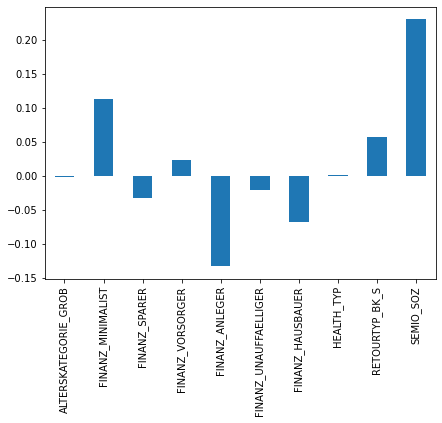

In [227]:
sorted_weights_3[:10].plot.bar(figsize=(7,5))

In [228]:
# now sorted by weight for third principal component
sorted_weights_3 = sorted_weights_3.sort_values(ascending=False)

<AxesSubplot:>

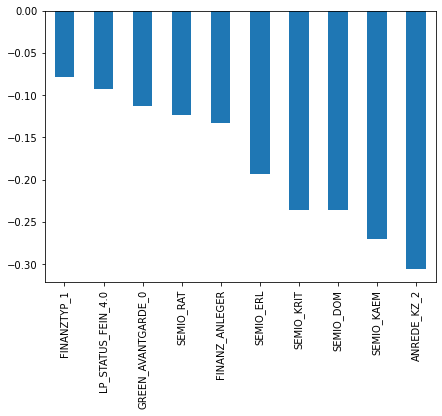

In [229]:
sorted_weights_3[-10:].plot.bar(figsize=(7,5))

In [230]:
df_weights = pd.DataFrame(sorted_weights_1)

In [231]:
df_weights['sorted_weights_2'] = sorted_weights_2

In [232]:
df_weights['sorted_weights_3'] = sorted_weights_3

In [233]:
df_weights.rename(columns={0:'sorted_weights_1'},inplace=True)

<AxesSubplot:>

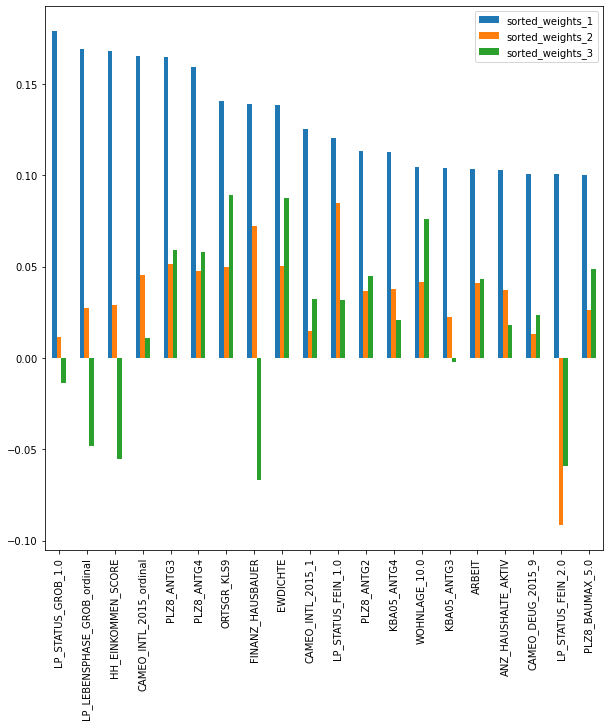

In [234]:
df_weights[0:20].plot.bar(figsize=(10,10))

<AxesSubplot:>

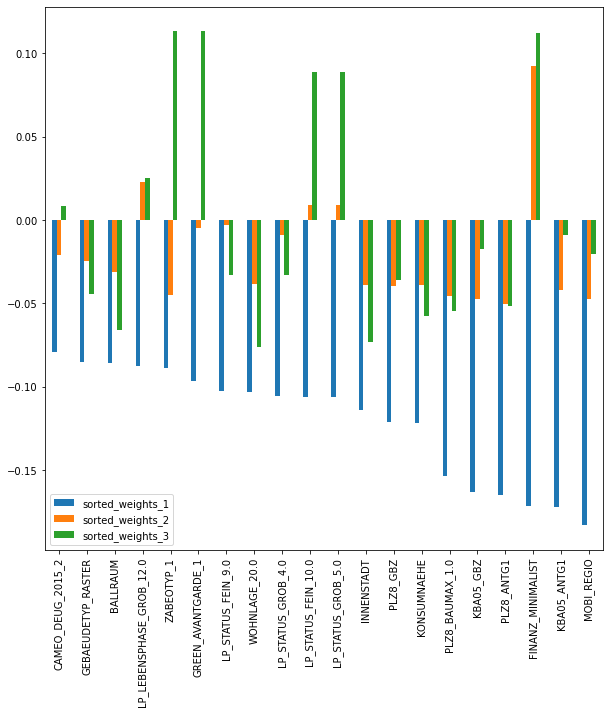

In [235]:
df_weights[-20:].plot.bar(figsize=(10,10))

In [236]:
def sorted_weights(n):
    #  weights_ser =
    return pd.Series(pca.components_[n], index=azdias_min_Nan.columns).sort_values(ascending=False)


### Discussion 2.3: Interpret Principal Components

I found that the weights of the elements differ from one component to another, as if each component is based on different elements, in addition to that negative values appear to mean a negative relationship to this element.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Over a number of different cluster counts

In [237]:
# Over a number of different cluster counts...

# kmeans = KMeans(n_clusters=50, random_state=0)
# kmeans = kmeans.fit(pca_data_tran)

    # run k-means clustering on the data and...
    
   
    # compute the average within-cluster distances.
    

In [238]:
def kmean_score(data, n):
    '''
    in_put:
           -'data' that you want to aplay kmean in it and get the score
           -'n'    number of center you want for your data
    out_put:
            - score of kmean model after aplaied in your data for n centers
    '''
    kmeans = KMeans(n_clusters= n , random_state=0)
    km_model = kmeans.fit(data)
    score = km_model.score(data)
    return score

In [239]:
scores = list()
for n in range(1,11):
    print(n)
    scores.append(kmean_score(pca_data_tran, n))
    print(kmean_score(pca_data_tran, n))

1
-98039527.17643952
2
-86325159.66981451
3
-80277353.06160319
4
-76270818.60704173
5
-73109800.01145843
6
-70203487.37656537
7
-68365933.75355633
8
-66225904.579762824
9
-63749391.08201372
10
-62260766.64126635


In [240]:
scores

[-98039527.17643952,
 -86325159.66981451,
 -80277353.06160319,
 -76270818.60704173,
 -73109800.01145843,
 -70203487.37656537,
 -68365933.75355633,
 -66225904.579762824,
 -63749391.08201372,
 -62260766.64126635]

In [241]:
len(scores)

10

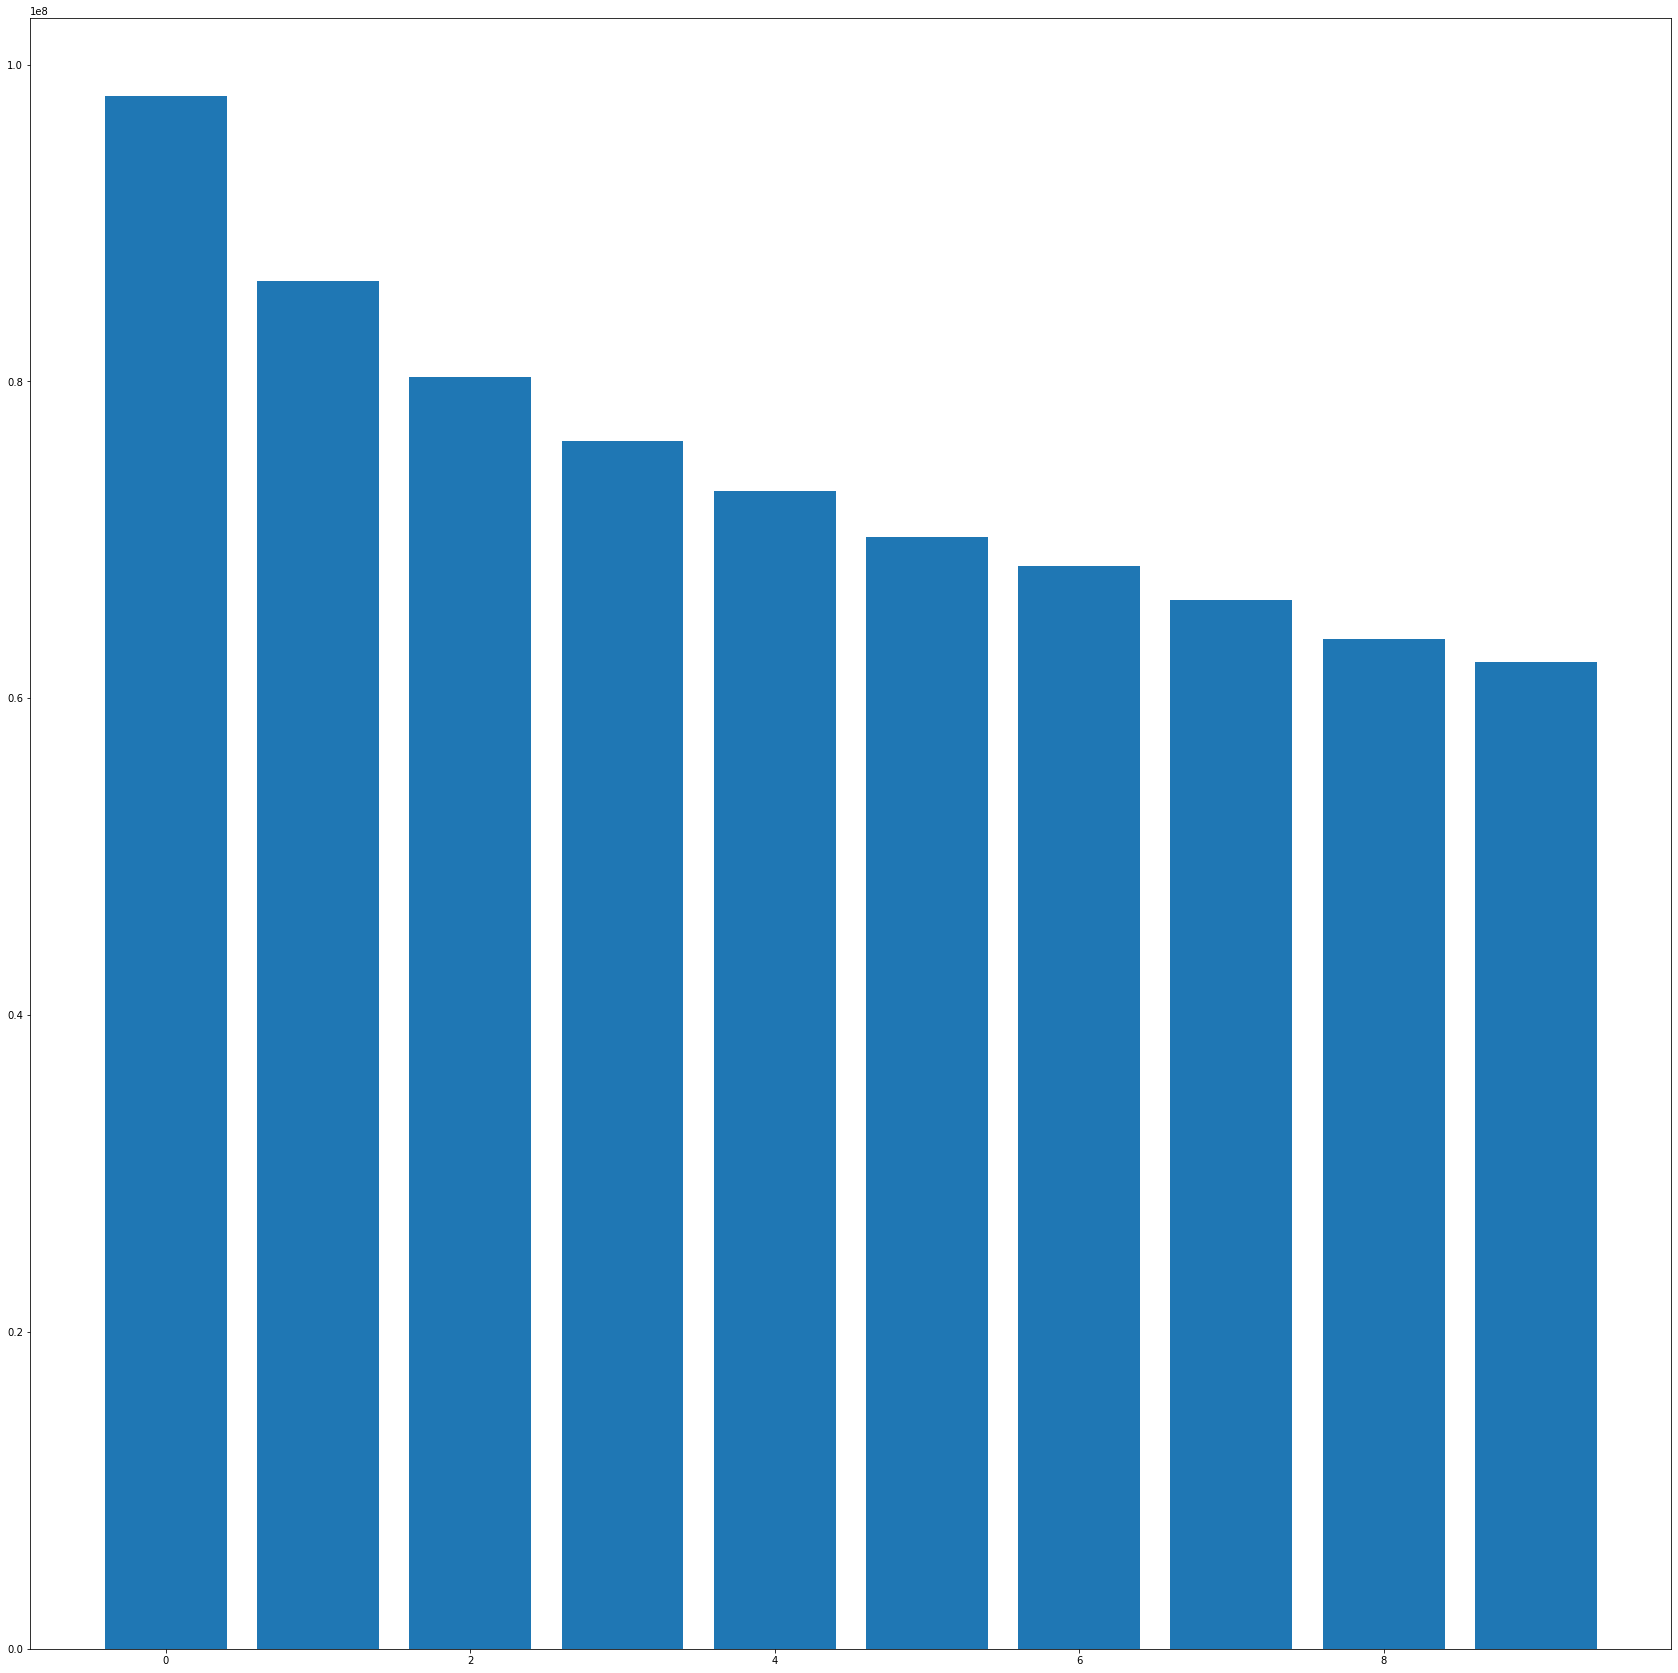

In [242]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

names = list(range(len(scores)))
values = [np.abs(a) for a in scores]

plt.figure(figsize=(100, 30))

plt.subplot(131)
plt.bar(names, values)
plt.show()

In [243]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(7, random_state=0)
km_model = kmeans.fit(pca_data_tran)
score = km_model.score(pca_data_tran)

In [244]:
len(km_model.labels_)

798276

In [245]:
km_model.labels_

array([5, 4, 0, ..., 6, 6, 1])

In [246]:
azdias_min_Nan.shape[0]

798276

In [247]:
# data frame for labels claster
df_labels_p = pd.DataFrame(km_model.labels_)
df_labels_p

,0
0,5
1,4
2,0
3,4
4,4
...,...
798271,6
798272,1
798273,6
798274,6


Litter 'p' in "df_labels_p" is an acronym for "the general population"

In [248]:
df_labels_p.groupby(by=0).indices.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

In [249]:
# dic for lebel : proportion 
label_proportion_p = {k:(v.size/azdias_min_Nan.shape[0]) for k,v in df_labels_p.groupby(by=0).indices.items()}
label_proportion_p

{0: 0.18493603716007997,
 1: 0.20098061322149233,
 2: 0.14154628223822338,
 3: 0.06221156592456744,
 4: 0.1255029588763786,
 5: 0.034436711112447324,
 6: 0.250385831466811}

In [250]:
df_label_proportion = pd.DataFrame(label_proportion_p.values(),columns=['proportion_population'])
df_label_proportion

,proportion_population
0,0.184936
1,0.200981
2,0.141546
3,0.062212
4,0.125503
5,0.034437
6,0.250386


In [251]:
sum(label_proportion_p.values())

1.0

In [252]:
total_size_group = 0
for k,b in df_labels_p.groupby(by=0).indices.items():
    print(k,b.size)
    total_size_group += b.size
total_size_group

0 147630
1 160438
2 112993
3 49662
4 100186
5 27490
6 199877


798276

### Discussion 3.1: Apply Clustering to General Population



It seems that choosing the number of centers or Clusters is not a definite matter. I think choosing 5 centers is a good choice, but I will choose 7 centers, if we want to be more specific.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data, obtaining cluster predictions for the customer demographics data.

In [253]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [254]:
customers.columns[0].split(';')

['AGER_TYP']

In [255]:
customers

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,1,3,1,4.0,5,1,5,1,1,2,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
191648,-1,4,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0


In [256]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

<ipython-input-193-9f1a7d7430a5>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_min_Nan['LP_LEBENSPHASE_GROB_ordinal'][azdias_min_Nan['LP_LEBENSPHASE_GROB'] == k] = v
<ipython-input-193-9f1a7d7430a5>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_min_Nan['LP_LEBENSPHASE_GROB_ordinal'][azdias_min_Nan['LP_LEBENSPHASE_GROB'] == k] = v
<ipython-input-193-9f1a7d7430a5>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az

In [257]:
customers_clean

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,4.0,5,1,5,1,2,2,1.0,5.0,6,...,0,0,0,0,0,1,0,0,0,0
2,4.0,5,1,5,1,4,4,2.0,5.0,2,...,0,0,0,0,0,0,0,1,0,0
3,4.0,5,1,5,2,1,2,2.0,3.0,6,...,0,0,0,0,0,1,0,0,0,0
4,3.0,3,1,4,4,5,2,3.0,5.0,4,...,0,0,0,0,0,0,1,0,0,0
5,3.0,5,1,5,1,2,3,3.0,3.0,6,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,3.0,5,1,5,1,1,2,3.0,5.0,6,...,0,0,0,0,0,0,1,0,0,0
191648,4.0,5,1,5,2,2,3,2.0,1.0,2,...,0,0,0,0,0,0,0,0,0,0
191649,4.0,5,1,5,1,1,2,2.0,3.0,4,...,0,0,0,0,1,1,0,0,0,0
191650,3.0,2,1,5,1,2,5,2.0,5.0,4,...,0,0,0,0,0,1,0,0,0,0


In [258]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imp_mean_c = SimpleImputer()
imp_mean_c.fit(customers_clean)
data_imp_c = imp_mean.transform(customers_clean)

# Apply feature scaling to the customer demographics data.

scaler_c = StandardScaler(with_mean=0, with_std=1)
data_scal_c = scaler.fit_transform(data_imp_c)

Litter 'c' is an acronym for "customer"

In [259]:
# Apply PCA to the data.
pca_data_tran_c = pca.transform(data_scal_c)

# kmean_score(data, n)

In [260]:
cluster_assignments_c = km_model.predict(pca_data_tran_c)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [261]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

df_labels_c = pd.DataFrame(cluster_assignments_c, columns=['customer_label'])

In [262]:
df_labels_c

,customer_label
0,0
1,0
2,0
3,0
4,2
...,...
141766,0
141767,0
141768,0
141769,0


In [263]:
df_labels_c.groupby(by='customer_label').indices[0]

array([     0,      1,      2, ..., 141768, 141769, 141770], dtype=int64)

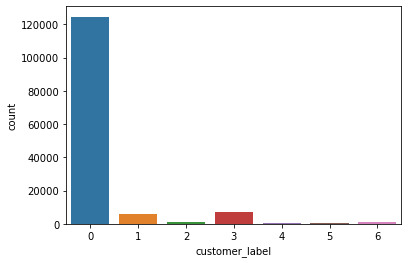

In [264]:
sns.countplot(x='customer_label', data=df_labels_c);

In [265]:
label_proportion_c = {k:(v.size/customers_clean.shape[0]) for k,v in df_labels_c.groupby(by='customer_label').indices.items() }
label_proportion_c

{0: 0.8783390115044685,
 1: 0.040325595502606316,
 2: 0.008337389169858433,
 3: 0.05250721233538594,
 4: 0.0058756727398410116,
 5: 0.005410133243046886,
 6: 0.00920498550479294}

In [266]:
pd.DataFrame.from_dict(label_proportion_c, orient='index', columns=['proportion_customer'])['proportion_customer']

0    0.878339
1    0.040326
2    0.008337
3    0.052507
4    0.005876
5    0.005410
6    0.009205
Name: proportion_customer, dtype: float64

In [267]:
df_label_proportion['proportion_customer'] = pd.DataFrame.from_dict(label_proportion_c, orient='index', columns=['proportion_customer'])['proportion_customer']

In [268]:
df_label_proportion

,proportion_population,proportion_customer
0,0.184936,0.878339
1,0.200981,0.040326
2,0.141546,0.008337
3,0.062212,0.052507
4,0.125503,0.005876
5,0.034437,0.005410
6,0.250386,0.009205


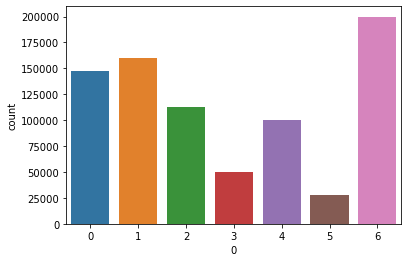

In [269]:
sns.countplot(x=0, data=df_labels_p);

In [270]:
# sns.countplot(x=0, data=df_labels_c);

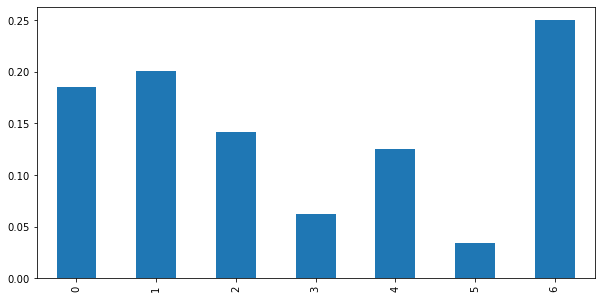

In [271]:
df_label_proportion['proportion_population'].plot.bar(figsize=(10,5));

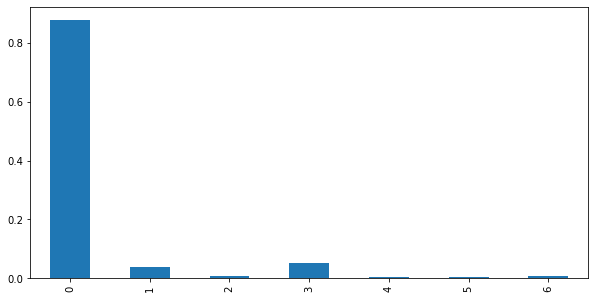

In [272]:
df_label_proportion['proportion_customer'].plot.bar(figsize=(10,5));

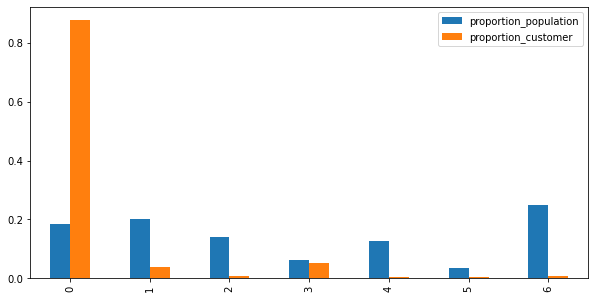

In [273]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

df_label_proportion.plot.bar(figsize=(10,5));

In [274]:
# We will look at this chart later

In [275]:
customers_clean_rest_index = customers_clean.reset_index()
customers_clean_rest_index

,index,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0,4.0,5,1,5,1,2,2,1.0,5.0,...,0,0,0,0,0,1,0,0,0,0
1,2,4.0,5,1,5,1,4,4,2.0,5.0,...,0,0,0,0,0,0,0,1,0,0
2,3,4.0,5,1,5,2,1,2,2.0,3.0,...,0,0,0,0,0,1,0,0,0,0
3,4,3.0,3,1,4,4,5,2,3.0,5.0,...,0,0,0,0,0,0,1,0,0,0
4,5,3.0,5,1,5,1,2,3,3.0,3.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141766,191647,3.0,5,1,5,1,1,2,3.0,5.0,...,0,0,0,0,0,0,1,0,0,0
141767,191648,4.0,5,1,5,2,2,3,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
141768,191649,4.0,5,1,5,1,1,2,2.0,3.0,...,0,0,0,0,1,1,0,0,0,0
141769,191650,3.0,2,1,5,1,2,5,2.0,5.0,...,0,0,0,0,0,1,0,0,0,0


In [276]:
df_labels_c

,customer_label
0,0
1,0
2,0
3,0
4,2
...,...
141766,0
141767,0
141768,0
141769,0


In [277]:
customers_clean_rest_index['customer_label'] = df_labels_c
customers_clean_rest_index

,index,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,customer_label
0,0,4.0,5,1,5,1,2,2,1.0,5.0,...,0,0,0,0,1,0,0,0,0,0
1,2,4.0,5,1,5,1,4,4,2.0,5.0,...,0,0,0,0,0,0,1,0,0,0
2,3,4.0,5,1,5,2,1,2,2.0,3.0,...,0,0,0,0,1,0,0,0,0,0
3,4,3.0,3,1,4,4,5,2,3.0,5.0,...,0,0,0,0,0,1,0,0,0,0
4,5,3.0,5,1,5,1,2,3,3.0,3.0,...,0,0,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141766,191647,3.0,5,1,5,1,1,2,3.0,5.0,...,0,0,0,0,0,1,0,0,0,0
141767,191648,4.0,5,1,5,2,2,3,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
141768,191649,4.0,5,1,5,1,1,2,2.0,3.0,...,0,0,0,1,1,0,0,0,0,0
141769,191650,3.0,2,1,5,1,2,5,2.0,5.0,...,0,0,0,0,1,0,0,0,0,0


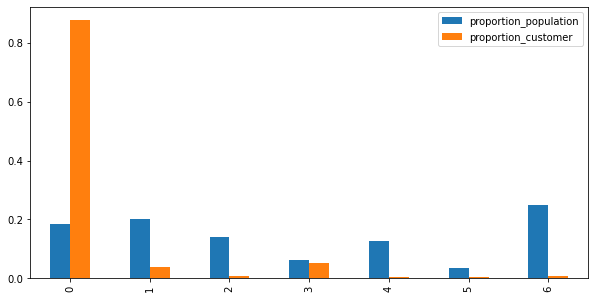

In [278]:
df_label_proportion.plot.bar(figsize=(10,5));

In [279]:
# As we can see, group "0" (or center "0") is much more represented in customers than it is in the general population.
# So we'll use it to see what it is.

In [280]:
label_0_indices = customers_clean_rest_index.groupby(by='customer_label').indices[0]
label_0_indices

array([     0,      1,      2, ..., 141768, 141769, 141770], dtype=int64)

In [281]:
df_customers_labels_0 = customers_clean_rest_index.iloc[label_0_indices,]
df_customers_labels_0

,index,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,customer_label
0,0,4.0,5,1,5,1,2,2,1.0,5.0,...,0,0,0,0,1,0,0,0,0,0
1,2,4.0,5,1,5,1,4,4,2.0,5.0,...,0,0,0,0,0,0,1,0,0,0
2,3,4.0,5,1,5,2,1,2,2.0,3.0,...,0,0,0,0,1,0,0,0,0,0
3,4,3.0,3,1,4,4,5,2,3.0,5.0,...,0,0,0,0,0,1,0,0,0,0
5,6,4.0,5,1,5,1,1,2,2.0,5.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141766,191647,3.0,5,1,5,1,1,2,3.0,5.0,...,0,0,0,0,0,1,0,0,0,0
141767,191648,4.0,5,1,5,2,2,3,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
141768,191649,4.0,5,1,5,1,1,2,2.0,3.0,...,0,0,0,1,1,0,0,0,0,0
141769,191650,3.0,2,1,5,1,2,5,2.0,5.0,...,0,0,0,0,1,0,0,0,0,0


In [282]:
# Back to the columns with higher weights
sorted_weights_1

LP_STATUS_GROB_1.0             0.178905
LP_LEBENSPHASE_GROB_ordinal    0.168930
HH_EINKOMMEN_SCORE             0.168245
CAMEO_INTL_2015_ordinal        0.165432
PLZ8_ANTG3                     0.164721
                                 ...   
KBA05_GBZ                     -0.162835
PLZ8_ANTG1                    -0.164952
FINANZ_MINIMALIST             -0.171328
KBA05_ANTG1                   -0.171962
MOBI_REGIO                    -0.183199
Length: 277, dtype: float64

In [283]:
sorted_weights_1.index[0:5]

Index(['LP_STATUS_GROB_1.0', 'LP_LEBENSPHASE_GROB_ordinal',
       'HH_EINKOMMEN_SCORE', 'CAMEO_INTL_2015_ordinal', 'PLZ8_ANTG3'],
      dtype='object')

In [284]:
# Given the higher weight columns in group "0"
df_customers_labels_0[sorted_weights_1.index[0:5]]

,LP_STATUS_GROB_1.0,LP_LEBENSPHASE_GROB_ordinal,HH_EINKOMMEN_SCORE,CAMEO_INTL_2015_ordinal,PLZ8_ANTG3
0,0,1.0,1.0,1.0,1.0
1,0,1.0,1.0,3.0,3.0
2,0,NaN,4.0,2.0,1.0
3,1,3.0,6.0,4.0,2.0
5,0,1.0,2.0,2.0,1.0
...,...,...,...,...,...
141766,0,1.0,1.0,1.0,2.0
141767,0,NaN,4.0,3.0,NaN
141768,0,1.0,4.0,2.0,2.0
141769,0,3.0,5.0,2.0,1.0


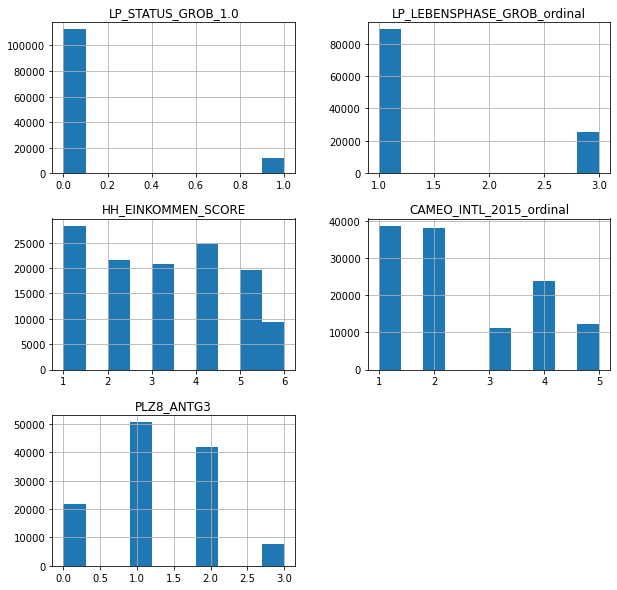

In [285]:
#  visualize Data  
df_customers_labels_0[sorted_weights_1.index[0:5]].hist(figsize=(10,10));

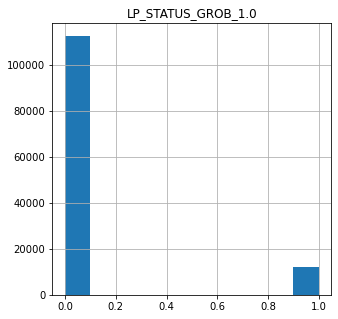

In [286]:
# We are satisfied with the first with the highest weight, as it shows a great discrepancy,
# and this will help us to come to a conclusion

df_customers_labels_0[sorted_weights_1.index[0:1]].hist(figsize=(5,5));


 back to the "Data_Dictionary" file,
 
 take a look to the column of highest weight here

### 1.16. LP_STATUS_GROB

Social status, rough scale

- 1: low-income earners (maps to 1-2 in fine scale)

- 2: average earners (maps to 3-5 in fine scale)

- 3: independents (maps to 6-7 in fine scale)

- 4: houseowners (maps to 8-9 in fine scale)

- 5: top earners (maps to 10 in fine scale)

We see that the graph shows us a lot, specifically that the  "1" and it takes the named column

LP_STATUS_GROB_1.0 

Here it takes the value "0", meaning that this segment is not represented, and it means, according to the above explanation, those with low incomes earners

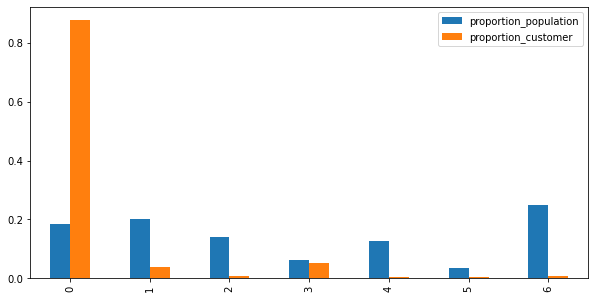

In [287]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

df_label_proportion.plot.bar(figsize=(10,5));

In [288]:
# We see here that Group No. "2" 
# presents us with a corresponding case for the first case that we dealt with.
# So we will analyze it.

In [289]:
label_2_indices = customers_clean_rest_index.groupby(by='customer_label').indices[2]
label_2_indices

array([     4,     82,    225, ..., 141244, 141556, 141596], dtype=int64)

In [290]:
df_customers_labels_2 = customers_clean_rest_index.iloc[label_2_indices,]
df_customers_labels_2

,index,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,customer_label
4,5,3.0,5,1,5,1,2,3,3.0,3.0,...,0,0,0,0,1,0,0,0,0,2
82,159,4.0,3,1,5,1,1,5,2.0,5.0,...,0,0,0,0,1,0,0,0,0,2
225,393,4.0,5,1,5,1,4,4,2.0,5.0,...,0,0,0,0,1,0,0,0,0,2
246,414,4.0,3,1,5,1,1,5,2.0,5.0,...,0,0,0,0,0,0,0,0,1,2
466,791,4.0,5,1,5,1,2,3,1.0,4.0,...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140932,190657,4.0,5,1,4,1,1,3,2.0,5.0,...,0,0,0,0,1,0,0,0,0,2
141163,190890,4.0,5,1,4,1,1,3,2.0,5.0,...,0,0,0,0,1,0,0,0,0,2
141244,190990,4.0,4,1,4,1,1,5,2.0,3.0,...,0,0,0,0,1,0,0,0,0,2
141556,191418,3.0,4,1,5,1,1,3,2.0,4.0,...,0,0,0,0,1,0,0,0,0,2


In [291]:
# Given the higher weight columns in group "2"
df_customers_labels_2[sorted_weights_1.index[0:5]]

,LP_STATUS_GROB_1.0,LP_LEBENSPHASE_GROB_ordinal,HH_EINKOMMEN_SCORE,CAMEO_INTL_2015_ordinal,PLZ8_ANTG3
4,0,1.0,1.0,3.0,2.0
82,0,1.0,4.0,3.0,1.0
225,0,NaN,4.0,3.0,1.0
246,0,3.0,3.0,3.0,2.0
466,0,1.0,4.0,3.0,3.0
...,...,...,...,...,...
140932,0,1.0,1.0,1.0,0.0
141163,0,1.0,3.0,3.0,2.0
141244,0,3.0,5.0,3.0,2.0
141556,0,1.0,1.0,3.0,1.0


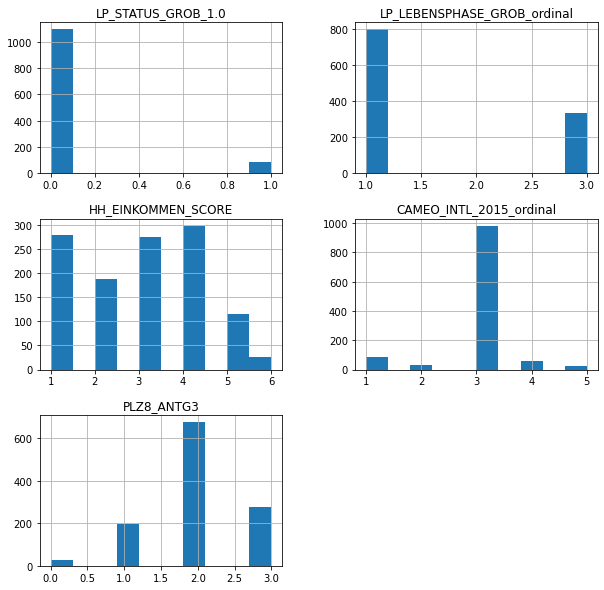

In [292]:
df_customers_labels_2[sorted_weights_1.index[0:5]].hist(figsize=(10,10));

Now we'll look at the second, heavier column, where we see a clear contrast, which is

LP_LEBENSPHASE_GROB

back to the "Data_Dictionary" file,

### 1.12. LP_LEBENSPHASE_GROB

Life stage, rough scale

-  1: single low-income and average earners of younger age

-  2: single low-income and average earners of higher age

-  3: single high-income earners

-  4: single low-income and average-earner couples

-  5: single high-income earner couples

-  6: single parents

-  7: single low-income and average earner families

-  8: high-income earner families

-  9: average earners of younger age from multiperson households

- 10: low-income and average earners of higher age from multiperson households

- 11: high-income earners of younger age from multiperson households

- 12: high-income earners of higher age from multiperson households


But we did : LP_LEBENSPHASE_GROB_ordinal

A new column represents this data in the following way 

In [293]:
dic_LP_LE_GR

{1: 3, 2: 3, 3: 1, 4: 3, 5: 1, 6: nan, 7: 3, 8: 1, 9: 2, 10: 3, 11: 1, 12: 1}

According to the graph, we find that the highest represented is "3".
According to our recoding, “3” stands for low income

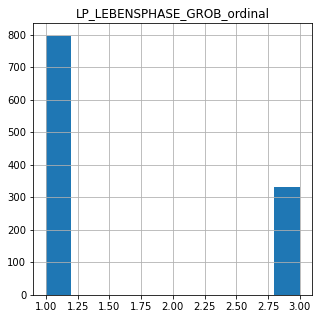

In [294]:
df_customers_labels_2[sorted_weights_1.index[1:2]].hist(figsize=(5,5));

### Discussion 3.3: Compare Customer Data to Demographics Data

Clearly, the representation between the two groups does not coincide, there is a large discrepancy, whereby customers, according to the data that we analyzed, are not reflected in the representation on the low-income segments, While the largest proportion of the population data is from the low-income group.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [295]:
# I encountered some problems on time, some processing took a long time,
# and time limitations affected some options and the final look of the project.

#Thanks for your kind review,
# and, I apologize for the few unclear, it's a matter of time again.